# Machine Learning Healkathon BPJS Competition


## Introduction

Studi yang dilakukan oleh William H. Shrank, dkk dalam jurnal berjudul Waste in the US Health Care System Estimated Costs and Potential for Savings menemukan bahwa sekitar 20-25% biaya pelayanan kesehatan di Amerika merupakan pemborosan (inefisiensi).
Jumlah tersebut cukup mengejutkan, namun bukan hal yang baru. Yang sangat mengejutkan adalah
bahwa betapa sedikitnya yang kita ketahui untuk mencegah hal tersebut terjadi.

Pada kasus kompetisi Machine Learning ini, mencari tahu bagaimana cara menentukan pelayana  kesehatan pada BPJS yang tergolong kedalam pelayanan `inefisiensi`.

## Data Preparation

### Load Dataset
Dokumentasi dataset: https://bafybeihnbhs3i3xilekqlih5beb27g6xizf6monfk34k2nch3thhyjwdla.ipfs.dweb.link/

Dataset adalah dataset tentang fasilitas kegiatan dari BPJS dimana terdapat 3 file dataset yang diberikan kepada kami yaitu:
- `Sampling_Healthkathon` merupakan data kunjungan peserta JKN ke fasilitas kesehatan rujukan tingkat lanjut
- `Sampling_Healthkathon_Diagnosa` merupakan data yang berisi diagnosa penyakit peserta, di mana dalam satu kunjungan peserta bisa memiliki lebih dari satu diagnosa. Terdiri dari 1 (satu) diagnosa primer dan atau satu atau lebih diagnosa sekunder. Diagnosa menggunakan ICD-10: https://icd.who.int/browse10/2016/en#/
- `Sampling_Healthkathon_Procedure` berupakan data yang berisi prosedur/tindakan medis yang didapatkan peserta JKN. Dalam setiap kunjungan, peserta bisa mendapatkan satu atau lebih prosedur/tindakan medis. Prosedur/tindakan medis menggunakan ICD9-CM: http://www.icd9data.com/2012/Volume3/default.htm

In [1]:
# Import Module pandas dan numpy
import pandas as pd
import numpy as np

In [2]:
# Load dataset
df_sampling = pd.read_csv('data/sampling_healtkathon2022/sampling_healtkathon2022.csv')
df_diagnosa = pd.read_csv('data/sampling_healthkathon2022_diagnosa/sampling_healthkathon2022_diagnosa.csv')
df_procedure = pd.read_csv('data/sampling_healthkathon2022_procedure/sampling_healthkathon2022_procedure.csv')

In [3]:
# Dimensi dari dataset
print(df_sampling.shape)
print(df_diagnosa.shape)
print(df_procedure.shape)

(11401882, 22)
(17308536, 3)
(12202871, 2)


In [4]:
# Data diagnosa
df_diagnosa.head()

,id,diag,levelid
0,6,O06.9,1
1,57,J02.9,1
2,91,R10.1,1
3,109,R18,1
4,111,N81.3,1


In [5]:
df_diagnosa.diag.value_counts()

I10       402538
K30       392093
Z09.8     368467
Z37.0     332678
D64.9     317982
           ...  
M01.87         1
95.41          1
M49.82         1
Y17.0          1
V80.6          1
Name: diag, Length: 13273, dtype: int64

Ada 13.273 jenis karakter yang berbeda, kode-kode ini adalah kode diagnosa penyakit yang sudah di tetapkan oleh penyedia data, misalnya untuk kode `K70` adalah kode untuk diagnosa dengan penyakit tergolong *liver* dan sebagainya. Untuk keterangan lebih lanjut mengenai kode diagnosa bisa di lihat di link berikut https://icd.who.int/browse10/2016/en#/

In [6]:
# Data Procedure
df_procedure.head()

,id,proc
0,6,90.59
1,6,69.01
2,6,88.78
3,27,90.59
4,27,88.78


In [7]:
df_procedure.proc.value_counts()

90.59    1510497
99.18     706424
89.52     583204
99.04     464487
99.21     361786
          ...   
78.90          1
33.52          1
14.39          1
37.66          1
36.03          1
Name: proc, Length: 3695, dtype: int64

Pada kolom `proc` ini berisi kode procedure/tindakan diagnosa misalnya jika antara nilai **08-16** adalah tindakan untuk pasien dengan penyakit pada *telinga* dan sebagainya. Dokumentasi lengkapnya bisa di lihat pada link berikut : http://www.icd9data.com/2012/Volume3/default.htm

Namun kami hanya menggunakan 1 file data saja yaitu `Sampling_Healthkathon` yang merupakan data inti, alasan kami tidak menggunakan file `Sampling_Healthkathon_Diagnosa` karena data ini berupa kode dari diagnosa penyakit dan tingkat diagnosanya, menurut kami dalam kasus efisiensi pelayanan, namun lebih tepat untuk kasus kesehatan
Sedangkan untuk file `Sampling_Healthkathon_Procedure` tidak kami gunakan krna hanya berisi kode prosedure dari tindakan medis dan memiliki banyak sekali kode yang berbeda bertype object, jadi sulit juga untuk pemodelan Machine Learning

In [8]:
df_sampling.head()

,id,id_peserta,dati2,typefaskes,usia,jenkel,pisat,tgldatang,tglpulang,jenispel,...,biaya,jenispulang,cbg,kelasrawat,kdsa,kdsp,kdsr,kdsi,kdsd,label
0,165666,486,17,KL,48,P,1.0,2018-07-25T17:00:00.000Z,2018-07-25T17:00:00.000Z,2,...,184300.0,1.0,Q-5-42-0,3,None,None,None,None,None,0
1,1010828,520,17,A,63,L,1.0,2019-05-27T17:00:00.000Z,2019-05-30T17:00:00.000Z,1,...,10628400.0,1.0,D-4-13-III,1,None,None,None,None,None,0
2,166042,523,17,KL,53,P,1.0,2019-07-16T17:00:00.000Z,2019-07-16T17:00:00.000Z,2,...,187300.0,1.0,Q-5-44-0,3,None,None,None,None,None,0
3,168937,549,17,KL,54,P,1.0,2019-10-17T17:00:00.000Z,2019-10-17T17:00:00.000Z,2,...,187300.0,1.0,Q-5-44-0,3,None,None,None,None,None,0
4,1005899,549,17,A,53,P,1.0,2018-04-18T17:00:00.000Z,2018-04-18T17:00:00.000Z,2,...,381600.0,1.0,Q-5-44-0,3,None,None,None,None,None,0


In [9]:
# Informasi dasar dataset
df_sampling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11401882 entries, 0 to 11401881
Data columns (total 22 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   id_peserta   int64  
 2   dati2        int64  
 3   typefaskes   object 
 4   usia         int64  
 5   jenkel       object 
 6   pisat        float64
 7   tgldatang    object 
 8   tglpulang    object 
 9   jenispel     int64  
 10  politujuan   object 
 11  diagfktp     object 
 12  biaya        float64
 13  jenispulang  float64
 14  cbg          object 
 15  kelasrawat   int64  
 16  kdsa         object 
 17  kdsp         object 
 18  kdsr         object 
 19  kdsi         object 
 20  kdsd         object 
 21  label        int64  
dtypes: float64(3), int64(7), object(12)
memory usage: 1.9+ GB


Data `Sampling_healkathon` terdiri dari 11401882 baris 22 kolom dimana dari kolom tersebut memiliki 3 type data floating point, 7 data integer dan 12 data object. 

## Data Cleansing

Materi konver [datetime](https://www.interviewqs.com/ddi-code-snippets/extract-month-year-pandas) pandas

In [10]:
# menghilangkan warnings
import warnings
warnings.filterwarnings('ignore')

# Merubah type object menjadi datetime
df_sampling['tgldatang'] = pd.to_datetime(df_sampling['tgldatang'], format='%Y-%m-%d %H:%M:%S')
df_sampling['tglpulang'] = pd.to_datetime(df_sampling['tglpulang'], format='%Y-%m-%d %H:%M:%S')

Pertama kita merubah type data dari kolom `tgldatang` dan `tglpulang` menjadi format *datetime* terlebih dahulu, karena ketika melihat informasi dari data, sebelumnya kedua kolom tersebut masih berupa data object

#### Mencari Data Hilang (missing values)

In [11]:
# Memilih nama kolom berdasarkan type data
num_cols = df_sampling.select_dtypes('number').columns
object_cols = df_sampling.select_dtypes('object').columns
print(num_cols)
print(object_cols)

Index(['id', 'id_peserta', 'dati2', 'usia', 'pisat', 'jenispel', 'biaya',
       'jenispulang', 'kelasrawat', 'label'],
      dtype='object')
Index(['typefaskes', 'jenkel', 'politujuan', 'diagfktp', 'cbg', 'kdsa', 'kdsp',
       'kdsr', 'kdsi', 'kdsd'],
      dtype='object')


In [12]:
# Check missing values numerical kolom
df_sampling[num_cols].isna().sum()

id                 0
id_peserta         0
dati2              0
usia               0
pisat            190
jenispel           0
biaya          57815
jenispulang       39
kelasrawat         0
label              0
dtype: int64

Kolom-kolom yang pertama kami analisis adalah kolom yang memiliki type data numeric yaitu antara *floating point dan integer*, dimana terdapat 3 kolom yang memiliki beberapa  data yang hilang.

#### Handling Missing Values

In [13]:
# Check jenis data
df_sampling.pisat.value_counts()

1.0    4874164
4.0    3350737
3.0    2474862
5.0     459397
2.0     242532
Name: pisat, dtype: int64

In [14]:
# Mengisi nilai hilang
df_sampling['pisat'] = df_sampling['pisat'].fillna(df_sampling['pisat'].mode()[0])

Untuk kolom `pisat` karena merupakan jenis data *ordinal* maka kami mengisi nilai yang hilang tersebut dengan nilai yang sering muncul dari kolom tersebut.

In [15]:
df_sampling.jenispulang.value_counts()

1.0    10929593
2.0      185714
4.0      146116
5.0       86835
3.0       53585
Name: jenispulang, dtype: int64

In [16]:
df_sampling['jenispulang'] = df_sampling['jenispulang'].fillna(df_sampling['jenispulang'].mode()[0])

Kemudian untuk kolom `jenispulang` karena berupa data ordinal juga maka kita mengisinya dengan *mode* juga.

Nah berbeda dengan kolom `biaya` karena berupa data *continue* dan memiliki banyak data yang hilang juga, jadi kami akan menebak nilai yang hilang tersebut dengan harga juga berdasarkan kolom lain dengan **Linear Regression**

In [17]:
selected_cols = ['biaya', 'id', 'id_peserta', 'dati2', 'jenispel', 'kelasrawat']
df_sampling[selected_cols].corr()

,biaya,id,id_peserta,dati2,jenispel,kelasrawat
biaya,1.000000,0.057408,0.055490,-0.030244,-0.447098,-0.317257
id,0.057408,1.000000,-0.010656,0.527575,-0.038642,-0.003628
id_peserta,0.055490,-0.010656,1.000000,0.036683,-0.127281,0.026998
dati2,-0.030244,0.527575,0.036683,1.000000,0.008881,-0.003250
jenispel,-0.447098,-0.038642,-0.127281,0.008881,1.000000,0.527171
kelasrawat,-0.317257,-0.003628,0.026998,-0.003250,0.527171,1.000000


In [18]:
from sklearn.linear_model import LinearRegression
# Membuat sebuah LinearRegression
lr = LinearRegression()

# Seleksi kolom-kolom yang digunakan
selected_cols = ['biaya', 'id', 'id_peserta', 'dati2', 'jenispel', 'kelasrawat']

# Bagi menjadi Missing dan Training. Missing Df berisi baris-baris dengan 'Biaya' kosong.
missing_df = df_sampling[df_sampling['biaya'].isnull()==True][selected_cols]
training_df = df_sampling[df_sampling['biaya'].isnull()==False][selected_cols]

# Buatlah model regression dari baris-baris yang tidak memiliki missing values
y_train = training_df['biaya']
x_train = training_df.drop('biaya', axis = 1)

lr.fit(x_train, y_train)

# Prediksilah nilai 'Biaya' pada baris-baris yang memiliki missing values
x_missing = missing_df.drop('biaya', axis = 1)

prediction = lr.predict(x_missing)
missing_df['biaya'] = prediction

In [19]:
### Combine all into one dataframe
df_full = pd.concat([training_df, missing_df])
df_full = df_full.sort_index()
df_full

,biaya,id,id_peserta,dati2,jenispel,kelasrawat
0,184300.0,165666,486,17,2,3
1,10628400.0,1010828,520,17,1,1
2,187300.0,166042,523,17,2,3
3,187300.0,168937,549,17,2,3
4,381600.0,1005899,549,17,2,3
...,...,...,...,...,...,...
11401877,3645100.0,9983563,8527704,301,1,3
11401878,12273200.0,11053870,8527709,233,1,2
11401879,4099000.0,7461049,8527751,118,1,3
11401880,3992400.0,1075162,8527853,101,1,3


In [20]:
# Memasukan nilai prediksi biaya 
df_update = df_sampling.copy()
df_update[selected_cols] = df_full[selected_cols]

In [21]:
df_update[num_cols].isna().sum()

id             0
id_peserta     0
dati2          0
usia           0
pisat          0
jenispel       0
biaya          0
jenispulang    0
kelasrawat     0
label          0
dtype: int64

Setelah kolom numeric sudah tidak memiliki nilai yang hilang, kemudian kita akan melakukan pengecekan pada kolom object

In [22]:
df_update[object_cols].isna().sum()

typefaskes          0
jenkel             49
politujuan    4041455
diagfktp         2530
cbg                 0
kdsa           198670
kdsp           197007
kdsr           198459
kdsi           198463
kdsd           195181
dtype: int64

Berbeda dengan kolom numeric, ternyata kolom object terdapat banyak nilai yang hilang, bahkan hanya ada 2 kolom saja yang memiliki data utuh

In [23]:
# Function check presentase data hilang
def hilang(data):
    miss = data.isna().mean()*100
    print('Missing: {:.2f}%'.format(miss))

In [24]:
hilang(df_update.politujuan)

Missing: 35.45%


In [25]:
hilang(df_update.kdsa)

Missing: 1.74%


In [26]:
df_update.kdsa.unique()

array(['None', nan, 'SF-4-10-III', 'SF-4-10-I', 'SF-4-13-III',
       'SF-4-10-II', 'SF-4-10-IV', 'SF-4-15-IV', 'SF-4-13-II',
       'SF-4-16-IV', 'SF-4-10-X', 'SF-4-16-III', 'SF-4-16-II',
       'SF-4-13-IV', 'SF-4-15-II', 'SF-4-11-IV', 'SF-4-13-X', 'SF-4-16-I',
       'SF-4-15-III', 'SF-4-13-I', 'SF-4-15-I', 'SF-4-16-X', 'SF-4-11-I',
       'ST-4-11-II', 'SA-4-14-X', 'SF-4-11-II', 'SF-4-19-I', 'SF-4-12-II',
       'SF-4-11-III', 'SF-4-19-IV', 'SA-4-14-II', 'SF-4-19-II',
       'SF-4-19-III', 'SA-4-14-I', 'ST-1-10-III', 'SF-4-18-I',
       'SF-4-15-X'], dtype=object)

In [27]:
df_update.kdsp.unique()

array(['None', nan, 'YY-10-III', 'YY-09-III', 'YY-01-II', 'YY-02-III',
       'YY-05-III', 'YY-08-III', 'YY-06-III', 'YY-07-III', 'YY-11-III',
       'YY-03-III', 'YY-04-III', 'YY-12-III'], dtype=object)

In [28]:
df_update.kdsr.unique()

array(['None', nan, 'RR-04-III', 'RR-02-II', 'RR-01-II', 'RR-05-III',
       'RR-03-III'], dtype=object)

In [29]:
df_update.kdsi.unique()

array(['None', 'II-02-III', nan, 'II-01-III', 'II-03-III'], dtype=object)

In [30]:
df_update.kdsd.unique()

array(['None', nan, 'DD-01-I', 'DD-05-II', 'DD-07-II', 'DD-06-II',
       'DD-04-II', 'DD-09-II', 'DD-10-II', 'DD-02-II', 'DD-03-II',
       'DD-08-II', 'DD-11-II'], dtype=object)

In [31]:
df_update.diagfktp.unique()

array(['L02.8', 'R23.1', 'E10.5', ..., 'm77.0', 'S45.8', 'E73.1'],
      dtype=object)

In [32]:
# Pilih nama kolom
hapus = ['diagfktp', 'politujuan']

# Hapus kolom
df_update.drop(hapus, axis=1, inplace=True)

Alasan kami menghapus kelima kolom tersebut, karena kolom tersebut memiliki banyak value data yang berbeda, ini akan sulit untuk melakukan **Feature Engineering** karena jika menggunakan *LabelEndcode* pada kolom tersebut maka bisa jadi Model Machine Learning akan mengira bukan data ordinal namun berupa data continue yang memiliki nilai lebih dan kurang.

Untuk kolom `politujuan` karena memiliki lebih dari 35% data yang hilangmaka dari itu kami putuskan untuk menghapusnya saja

<AxesSubplot:>

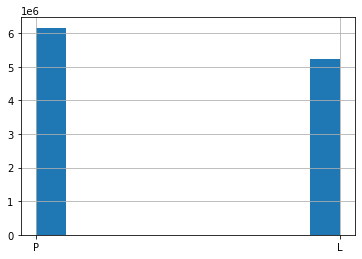

In [33]:
df_update['jenkel'].hist()

In [34]:
# Mengisi data hilang dengan mode
df_update['jenkel'] = df_update['jenkel'].fillna('P')

Mengisikan data hilang pada kolom `jenkel` dengan nilai mode berupa *P* memang akan menjadikan nilai tersebut lebih dominan, namun dirumah sakit manapun kebutuhan pelayanan kesehatan memang cenderung banyak pengunjung yang berjenis kelamin wanita, karena wanita memiliki kepentingan seperti melahirkan, posyandu, check up kehamilan dan sebagainya.

In [35]:
df_update.columns

Index(['id', 'id_peserta', 'dati2', 'typefaskes', 'usia', 'jenkel', 'pisat',
       'tgldatang', 'tglpulang', 'jenispel', 'biaya', 'jenispulang', 'cbg',
       'kelasrawat', 'kdsa', 'kdsp', 'kdsr', 'kdsi', 'kdsd', 'label'],
      dtype='object')

In [36]:
df_update['kdsr'] = df_update['kdsr'].fillna(method='pad')
df_update['kdsi'] = df_update['kdsi'].fillna(method='pad')
df_update['kdsp'] = df_update['kdsp'].fillna(method='pad')
df_update['kdsd'] = df_update['kdsd'].fillna(method='pad')
df_update['kdsa'] = df_update['kdsa'].fillna(method='pad')

Untuk kolom `kdsr, kdsi, kdsp, kdsd` kami mengisinya dengan nilai sebelum atau sesudahnya karena data ini berupa kode khusus jadi tidak mengkin mengisinya dengan mode juga.

In [38]:
object_cols = df_update.select_dtypes('object').columns

df_update[object_cols].isna().sum()

typefaskes    0
jenkel        0
cbg           0
kdsa          0
kdsp          0
kdsr          0
kdsi          0
kdsd          0
dtype: int64

Setelah tidak ada lagi missing value maka kita akan melakukan visualisasi data untuk melihat gambaran dari data object ini

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [40]:
def plot_all_hist(df, columns):
    for col in columns:
        plt.figure(figsize=(10,6))
        sns.countplot(x=col, data=df)
        plt.xlabel(col.capitalize())
        plt.xticks(rotation='90')
        plt.tight_layout()
        plt.show()

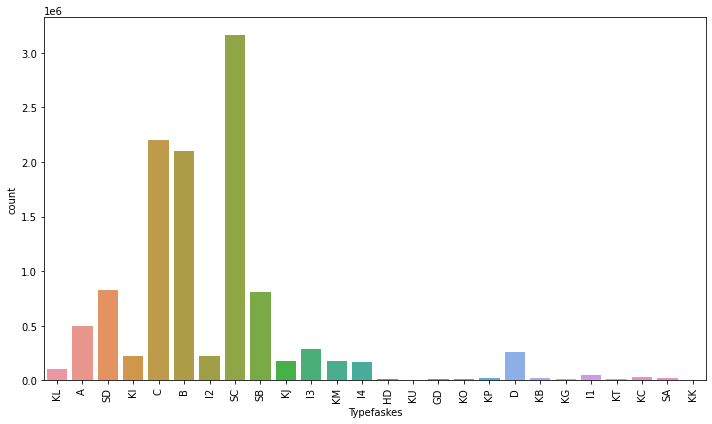

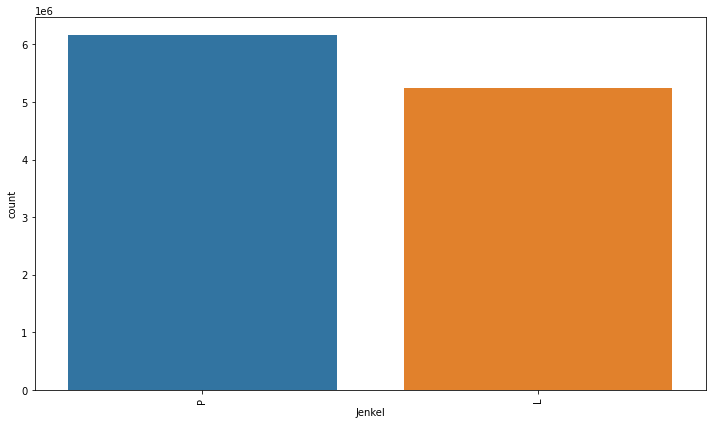

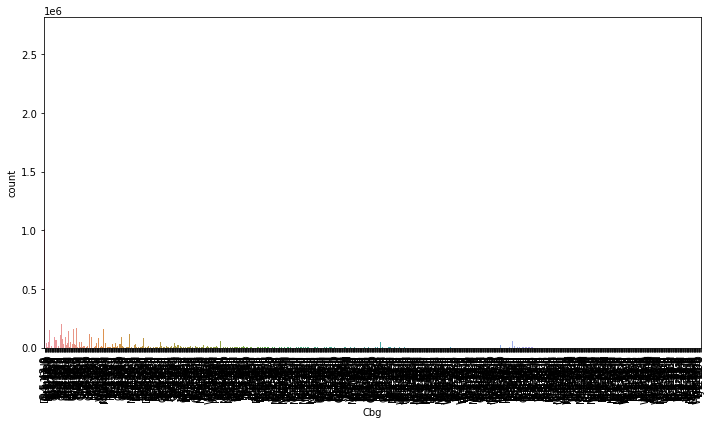

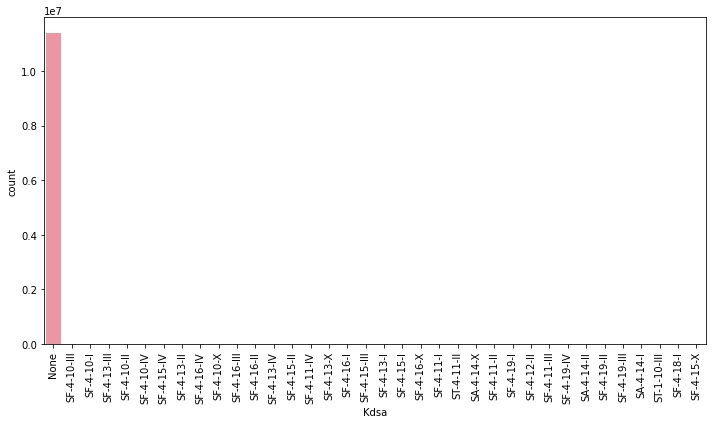

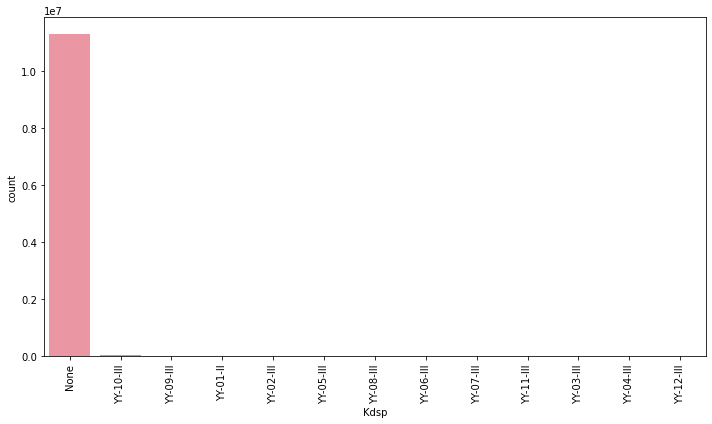

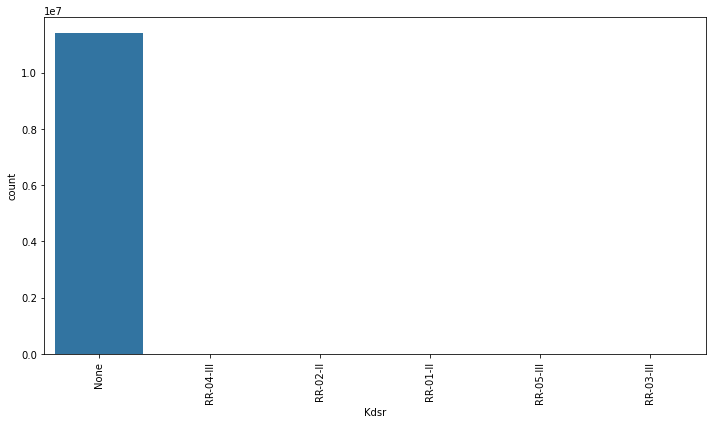

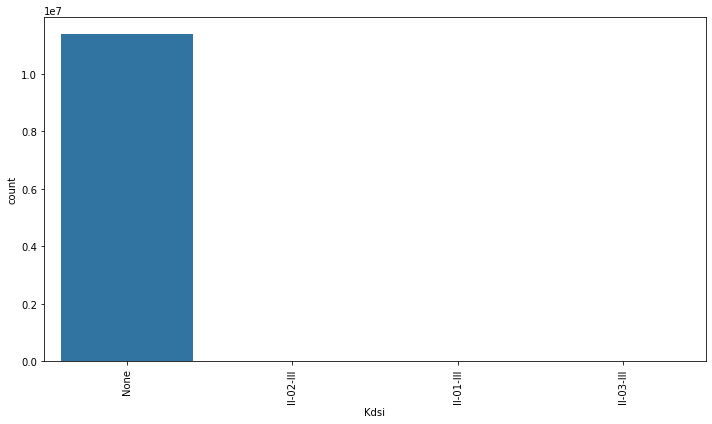

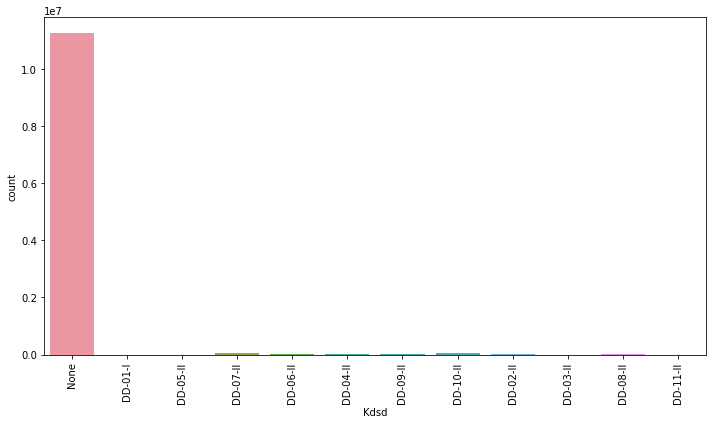

In [41]:
plot_all_hist(df_update, object_cols)

In [42]:
df_update.cbg.value_counts()

Q-5-44-0      2678848
Q-5-42-0      1012559
F-5-14-0       289409
P-8-17-I       248339
U-3-15-0       219126
               ...   
L-2-21-0            1
I-2-42-0            1
M-1-05-III          1
J-4-10-II           1
J-2-31-0            1
Name: cbg, Length: 1034, dtype: int64

Wajar saja jika kolom `kdsr dan kdsi` memiliki nilai None dengan jumlah yang begitu banyak, karena kode tersebut merupakan kode spesial dari para kunjungan oleh karena itu sangat jarang sekali yang menggunaknnya.

Nah untuk kolom `cbg` saya baru mengetahuinya ternyata kolom ini juga merupakan data dengan kombinasi angka dan huruf(code) maka dari itu kami juga tidak akan menggunakan kolom ini.

In [43]:
# Drop kolom cbg
df_update.drop('cbg', axis=1, inplace=True)

In [44]:
df_update.head()

,id,id_peserta,dati2,typefaskes,usia,jenkel,pisat,tgldatang,tglpulang,jenispel,biaya,jenispulang,kelasrawat,kdsa,kdsp,kdsr,kdsi,kdsd,label
0,165666,486,17,KL,48,P,1.0,2018-07-25 17:00:00+00:00,2018-07-25 17:00:00+00:00,2,184300.0,1.0,3,None,None,None,None,None,0
1,1010828,520,17,A,63,L,1.0,2019-05-27 17:00:00+00:00,2019-05-30 17:00:00+00:00,1,10628400.0,1.0,1,None,None,None,None,None,0
2,166042,523,17,KL,53,P,1.0,2019-07-16 17:00:00+00:00,2019-07-16 17:00:00+00:00,2,187300.0,1.0,3,None,None,None,None,None,0
3,168937,549,17,KL,54,P,1.0,2019-10-17 17:00:00+00:00,2019-10-17 17:00:00+00:00,2,187300.0,1.0,3,None,None,None,None,None,0
4,1005899,549,17,A,53,P,1.0,2018-04-18 17:00:00+00:00,2018-04-18 17:00:00+00:00,2,381600.0,1.0,3,None,None,None,None,None,0


## Exploratory Data Analysis

In [45]:
import seaborn as sns

In [46]:
def plot_num_histogram(columns):
    for col in columns:
        plt.figure(figsize=(10,6))
        sns.histplot(df_update[col], bins=20)
        plt.show()

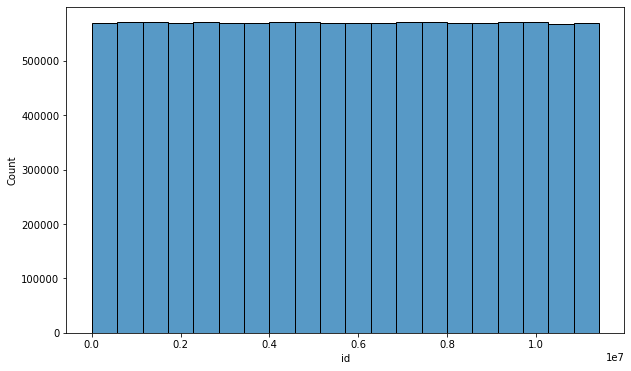

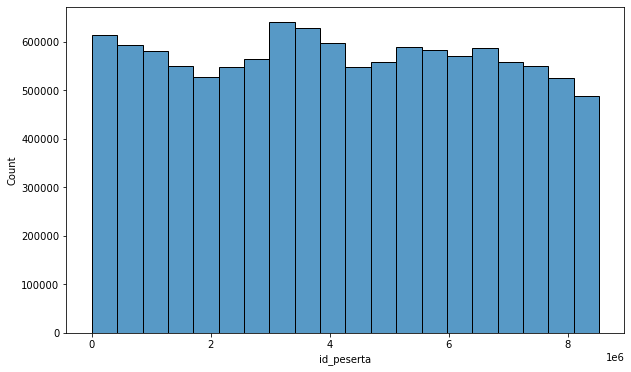

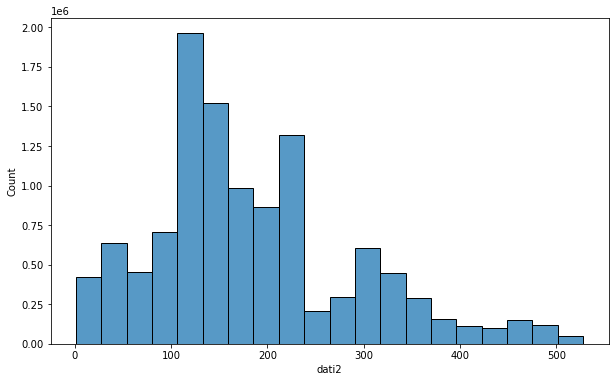

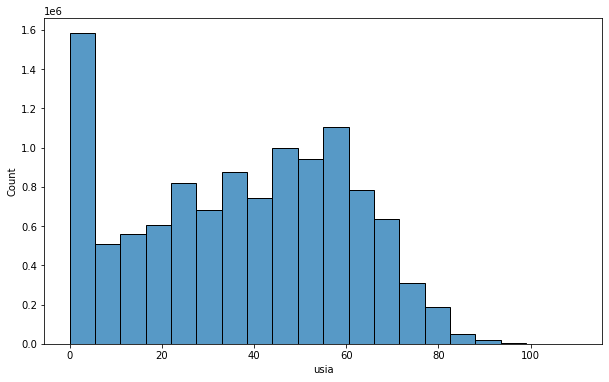

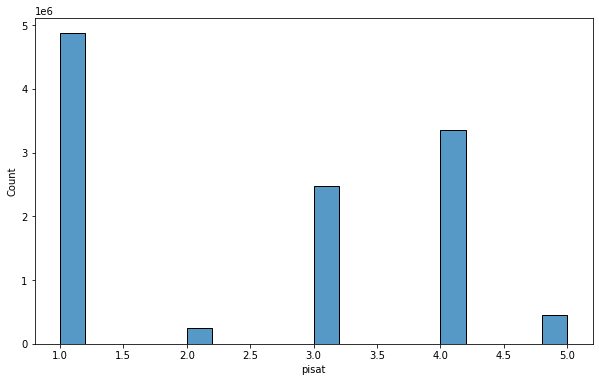

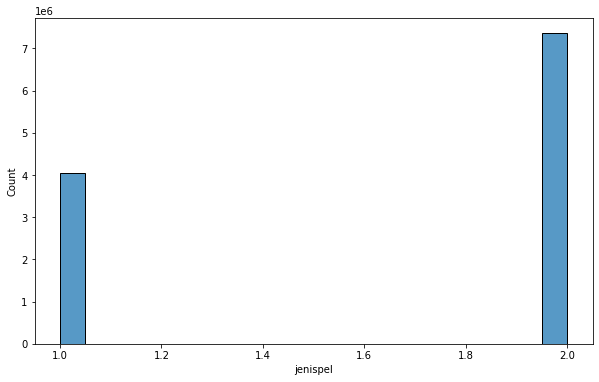

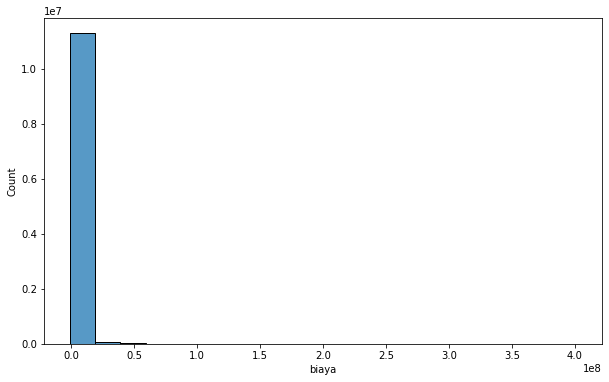

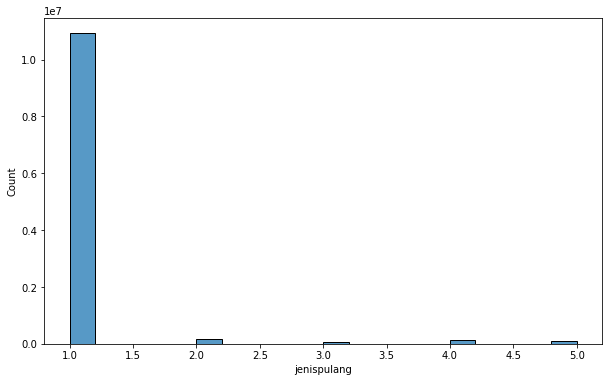

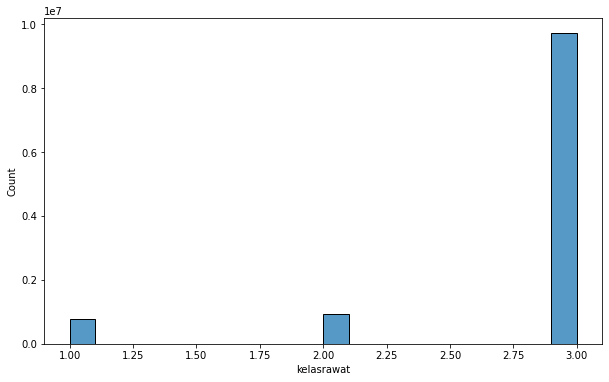

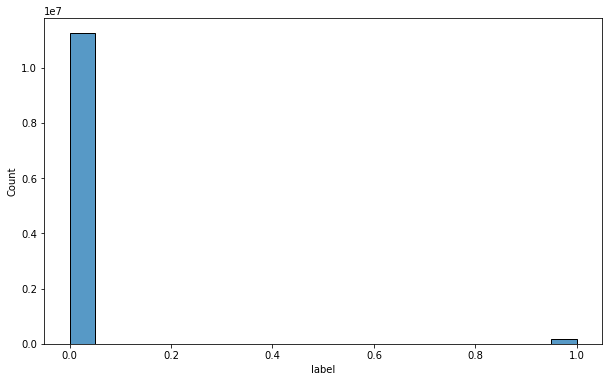

In [47]:
plot_num_histogram(num_cols)

Dari hasil visualisasi ditemukan bahwa usia yang melakukan kunjungan pada BPJS paling banyak berasal dari kalangan *Balita*

Selain itu untuk jenispulang, sangat dominan sekali pada kenis 1 sedangkan 2,3,4,5 seperti tidak memiliki banyak perbedaan

Kemudian untuk kelasrawat ternyata mayoritas kunjungan lebih memiliki kelas 3 sebagai kamar kelas rawat mereka

In [48]:
# Jenis kelamin dan biaya
df_update.groupby("jenkel").agg({"biaya": ["sum", "max", "mean"]})

biaya                           
                 sum          max          mean
jenkel                                         
L       1.193248e+13  401696600.0  2.277122e+06
P       1.253527e+13  400505800.0  2.034377e+06

Terlihat antara kunjungan laki-laki dan perempuan memang total biaya lebih banyak pada perempuan, karena mengingat lebih banyak pengunjung perempuan. 

Untuk biaya yang di keluarkan paling besar sepertinya imbang, namun rata-rata dari biaya keduanya terlihatlebih tinggi dari laki-laki, ini bisa saja terjadi karena laki-laki pasti memiliki kasus yang berbeda beda dalam diagnosa penyakitnya sehingga memicu perbedaan biaya yang jauh tergantung pelayanan yang di lakukan dan mengakibatkan nilai rata-ratanya.

In [49]:
# Typefaskes | biaya dan usia
df_update.groupby('typefaskes').agg({'biaya':['max', 'count'], 'usia':'mean'})

biaya                usia
                    max    count       mean
typefaskes                                 
A           401696600.0   493055  32.738114
B           202643500.0  2102708  36.953400
C           126268400.0  2197424  37.124911
D            52485500.0   260327  36.770623
GD           97440200.0     9273  40.177397
HD           71880400.0    14390  52.062404
I1          207675700.0    49979  41.011145
I2          129672900.0   226470  39.232724
I3           49847700.0   285780  38.783638
I4           42260700.0   164106  35.652304
KB           58351800.0    25479  39.095255
KC          233635200.0    28917  29.560812
KG           27194700.0    11134  37.142985
KI          312535300.0   221114  15.843936
KJ           90159400.0   173692  36.839071
KK            4324000.0        9  49.333333
KL          207675700.0   101933  42.533713
KM           22226400.0   177017  49.117876
KO          233635200.0    12804  48.150109
KP          207675700.0    17850  44.910420
KT          178007700.0     7375  34.031322
KU           49164900.0     4180  47.908612
SA          213906000.0    17174  34.616979
SB          160030800.0   808444  39.025975
SC          128514200.0  3165558  37.069411
SD           45455900.0   825690  38.725619

Dari `typefaskes` ini ada satu fasilitas kesehatan yang hanya terdapat 9 pengunjung yaitu **KK** dimana rata-rata pengunjungnya adalah lansia dengan maximum biaya yang tidak cukup tinggi.

Sedangkan untuk fasilitas **KI** terlihat bahwa rata-rata pengunjung adalah anak-anak, mungkin saja fasilitas ini memang khusus untuk melayani anak-anak.

Selain itu fasilitas **A** merupakan fasilitas dengan maximum biaya yang paling tinggi diantara yang lainya, dengan rata-rata pengunjung merupakan orang-orang dewasa

In [50]:
df_update.groupby('kelasrawat').agg({'biaya':['max', 'count'], 'usia':'mean'})

biaya                usia
                    max    count       mean
kelasrawat                                 
1           401696600.0   768570  40.178835
2           343290700.0   917742  29.949720
3           283523900.0  9715570  37.481284

Kmudian untuk `kelasrawat` seperti visualisasi sebelumnya bahwa memang kebanyakan pengunjung lebih memilih pada kelas 3, ini menyangkut karena kelas 1 memiliki tarif yang begitu tinggi sehingga orang lebih banyak memilih kelasrawat yang biasa biasa saja asalkan bisa sembuh.

In [51]:
# Measure dataset
df_update.describe()

,id,id_peserta,dati2,usia,pisat,jenispel,biaya,jenispulang,kelasrawat,label
count,1.140188e+07,1.140188e+07,1.140188e+07,1.140188e+07,1.140188e+07,1.140188e+07,1.140188e+07,1.140188e+07,1.140188e+07,1.140188e+07
mean,5.712720e+06,4.199294e+06,1.825299e+02,3.705690e+01,2.498179e+00,1.645544e+00,2.145939e+06,1.094596e+00,2.784695e+00,1.375992e-02
std,3.298535e+06,2.436249e+06,1.061352e+02,2.292188e+01,1.390865e+00,4.783482e-01,5.196992e+06,5.131545e-01,5.511473e-01,1.164929e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-1.425999e+06,1.000000e+00,1.000000e+00,0.000000e+00
25%,2.855432e+06,2.119461e+06,1.140000e+02,1.800000e+01,1.000000e+00,1.000000e+00,1.904000e+05,1.000000e+00,3.000000e+00,0.000000e+00
50%,5.712226e+06,4.161532e+06,1.590000e+02,3.900000e+01,3.000000e+00,2.000000e+00,2.886000e+05,1.000000e+00,3.000000e+00,0.000000e+00
75%,8.568902e+06,6.292149e+06,2.280000e+02,5.600000e+01,4.000000e+00,2.000000e+00,3.003200e+06,1.000000e+00,3.000000e+00,0.000000e+00
max,1.142696e+07,8.527919e+06,5.280000e+02,1.100000e+02,5.000000e+00,2.000000e+00,4.016966e+08,5.000000e+00,3.000000e+00,1.000000e+00


In [52]:
# Lama inap pengunjung
lama_inap = df_update['tglpulang']-df_update['tgldatang']

In [53]:
lama_inap.describe()

count                     11401882
mean     1 days 12:35:56.763944759
std      5 days 07:04:13.172048229
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:00:00
75%                2 days 00:00:00
max             1431 days 00:00:00
dtype: object

Pada lama inap ini saya sedikit terkejut karena nilai maximumnya adalah 1431, ternyata ada pengunjung yang di rawat sampai begitu lama

In [54]:
df_update.corr()

,id,id_peserta,dati2,usia,pisat,jenispel,biaya,jenispulang,kelasrawat,label
id,1.000000,-0.010656,0.527575,0.011832,0.003247,-0.038642,0.057390,0.037123,-0.003628,0.002648
id_peserta,-0.010656,1.000000,0.036683,-0.405294,0.217696,-0.127281,0.056062,0.012898,0.026998,0.010491
dati2,0.527575,0.036683,1.000000,0.000736,0.000708,0.008881,-0.030411,-0.006446,-0.003250,0.007179
usia,0.011832,-0.405294,0.000736,1.000000,-0.570092,0.113925,-0.044835,0.029344,0.011967,-0.011001
pisat,0.003247,0.217696,0.000708,-0.570092,1.000000,-0.091614,0.033036,-0.010627,0.015167,0.007748
jenispel,-0.038642,-0.127281,0.008881,0.113925,-0.091614,1.000000,-0.447931,-0.079056,0.527171,0.003210
biaya,0.057390,0.056062,-0.030411,-0.044835,0.033036,-0.447931,1.000000,0.129765,-0.317811,0.001240
jenispulang,0.037123,0.012898,-0.006446,0.029344,-0.010627,-0.079056,0.129765,1.000000,-0.025196,-0.002402
kelasrawat,-0.003628,0.026998,-0.003250,0.011967,0.015167,0.527171,-0.317811,-0.025196,1.000000,-0.004448
label,0.002648,0.010491,0.007179,-0.011001,0.007748,0.003210,0.001240,-0.002402,-0.004448,1.000000


<AxesSubplot:>

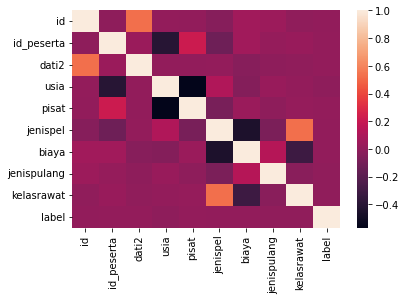

In [55]:
sns.heatmap(df_update.corr())

In [56]:
# Data label 1
label_1 = df_update.loc[df_update['label']==1]

In [57]:
label_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156889 entries, 20 to 11401854
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   id           156889 non-null  int64              
 1   id_peserta   156889 non-null  int64              
 2   dati2        156889 non-null  int64              
 3   typefaskes   156889 non-null  object             
 4   usia         156889 non-null  int64              
 5   jenkel       156889 non-null  object             
 6   pisat        156889 non-null  float64            
 7   tgldatang    156889 non-null  datetime64[ns, UTC]
 8   tglpulang    156889 non-null  datetime64[ns, UTC]
 9   jenispel     156889 non-null  int64              
 10  biaya        156889 non-null  float64            
 11  jenispulang  156889 non-null  float64            
 12  kelasrawat   156889 non-null  int64              
 13  kdsa         156889 non-null  object             
 14  k

In [58]:
# Maximum biaya label 1
label_1.biaya.max()

309451300.0

In [59]:
# Descriptif label 1
label_1.describe()

,id,id_peserta,dati2,usia,pisat,jenispel,biaya,jenispulang,kelasrawat,label
count,1.568890e+05,1.568890e+05,156889.000000,156889.000000,156889.000000,156889.000000,1.568890e+05,156889.000000,156889.000000,156889.0
mean,5.786660e+06,4.415679e+06,188.981063,34.922034,2.589410,1.658542,2.200517e+06,1.084161,2.763941,1.0
std,3.289052e+06,2.563850e+06,109.591406,24.302000,1.409184,0.474200,4.548593e+06,0.460258,0.565000,0.0
min,1.300000e+01,1.020000e+02,1.000000,0.000000,1.000000,1.000000,-1.425999e+06,1.000000,1.000000,1.0
25%,3.100973e+06,2.170715e+06,114.000000,12.000000,1.000000,1.000000,2.106000e+05,1.000000,3.000000,1.0
50%,5.734898e+06,4.417797e+06,173.000000,37.000000,3.000000,2.000000,5.195000e+05,1.000000,3.000000,1.0
75%,8.717727e+06,6.787155e+06,238.000000,55.000000,4.000000,2.000000,3.883300e+06,1.000000,3.000000,1.0
max,1.142688e+07,8.527871e+06,528.000000,105.000000,5.000000,2.000000,3.094513e+08,5.000000,3.000000,1.0


In [60]:
df_update.biaya.max()

401696600.0

Setelah melihat gambaran dari data yang berlabel 1, kita belum menemukan apa saja kolom yang menyebalkan suatu pelayanan tergolong tidak efisien, di lihat dari kolom-kolom lain datanya seperti sama saja dengan data berlabel 0, namun dari biaya tidak memiliki nilai maximum mencapai data berlabel 0 dimana maximum nya = 401696600.0, sedangkan label 1 = 309451300.0

Namun kita akan mencoba untuk lebih meneliti perbedaan diantara kedua label tersebut

In [61]:
# Lama rawat label 1
lama = label_1['tglpulang']-label_1['tgldatang']

In [62]:
lama.describe()

count                       156889
mean     1 days 04:11:11.771762201
std      7 days 11:26:48.573826831
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:00:00
75%                2 days 00:00:00
max              655 days 00:00:00
dtype: object

In [63]:
# Kolom label 1 object
label_object = label_1.select_dtypes('object').columns

# Data dengan label 0
label_0 = df_update.loc[df_update['label']==0]

In [64]:
def plot_all_object(df1, df2, columns):
    for col in columns:
        plt.figure(figsize=(14,6))
        # Sublots sisi kiri
        plt.subplot(1,2,1)
        sns.countplot(x=col, data=df1)
        plt.xlabel(col.capitalize())
        plt.xticks(rotation='90')
        plt.tight_layout()
        #Subplots sisi kanan
        plt.subplot(1,2,2)
        sns.countplot(x=col, data=df2)
        plt.xlabel(col.capitalize())
        plt.xticks(rotation='90')
        plt.tight_layout()
        plt.show()

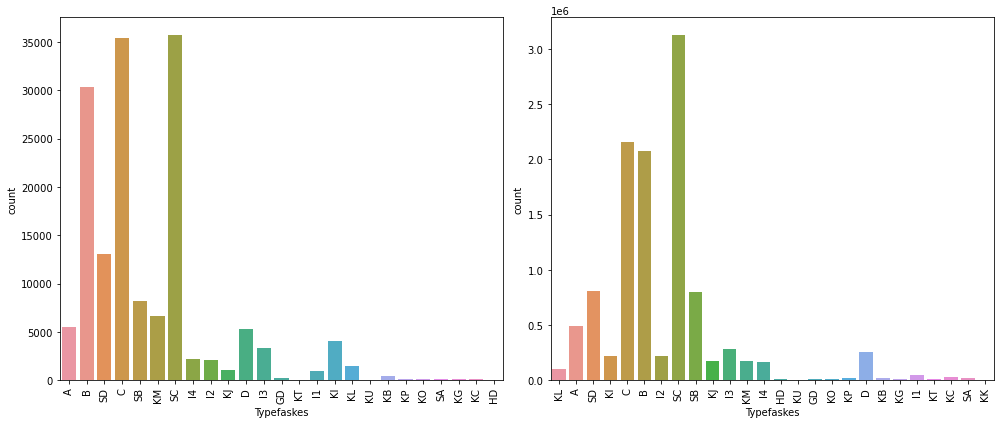

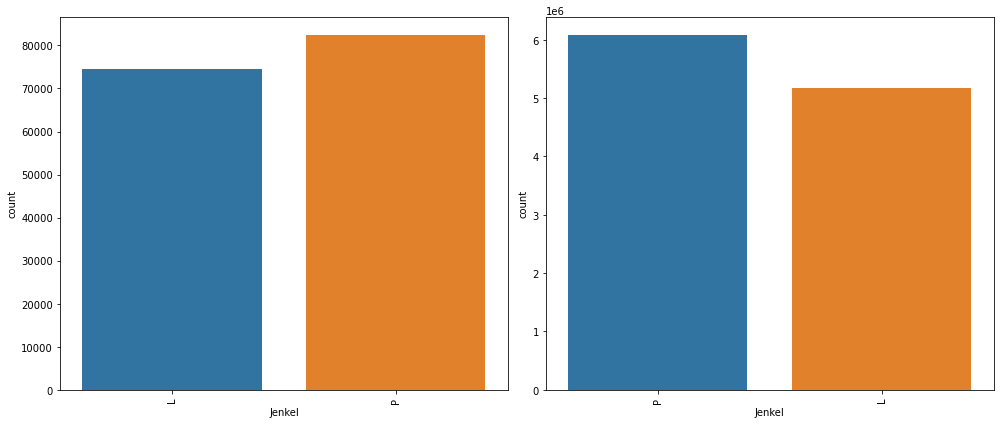

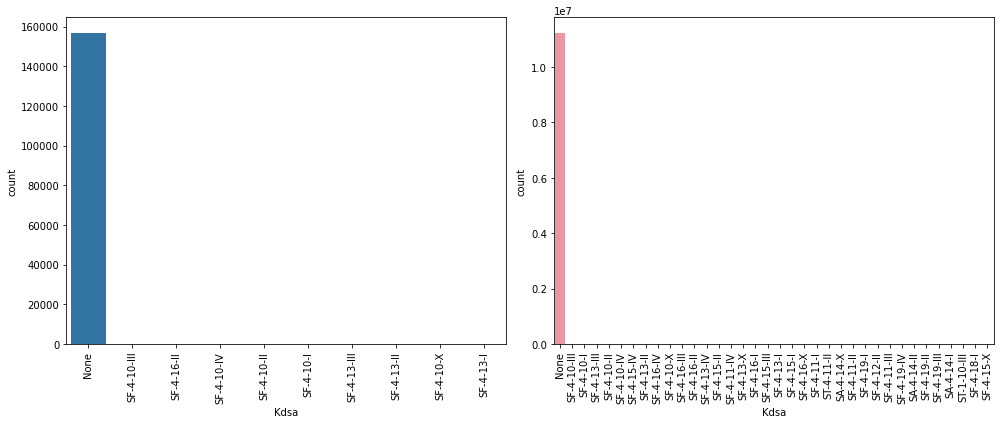

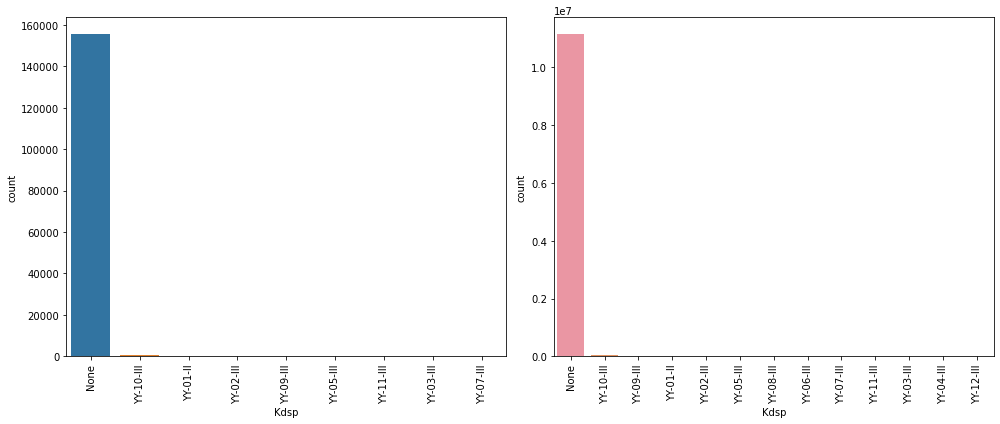

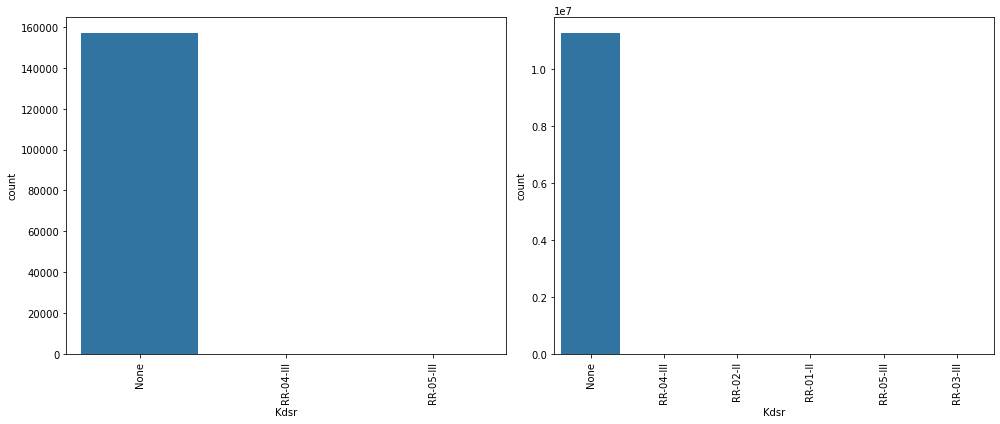

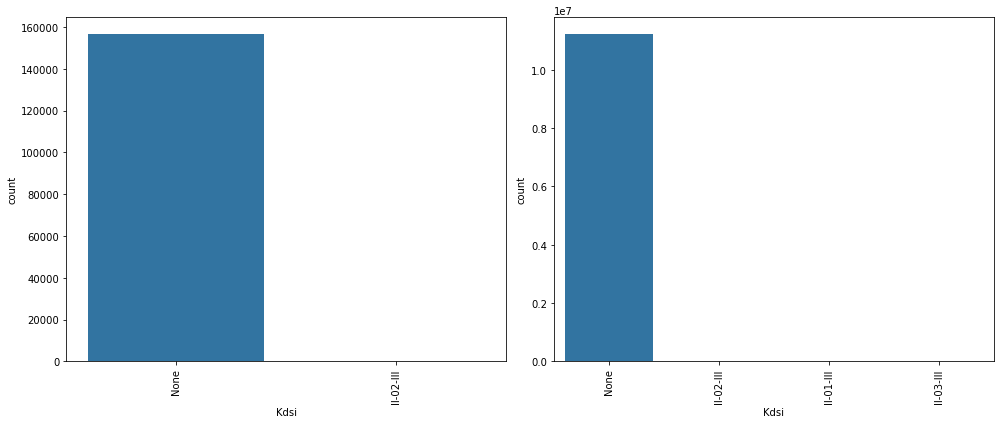

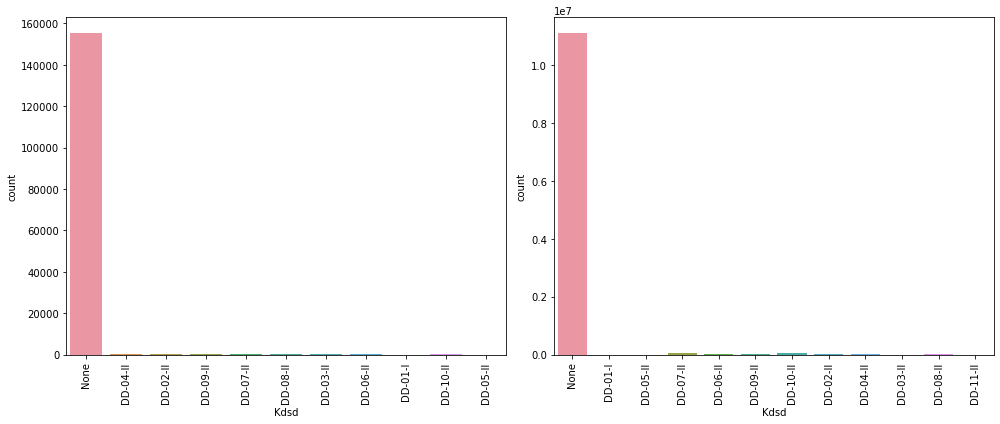

In [65]:
# Kiri label 1 kanan label 0
plot_all_object(label_1, label_0, label_object)

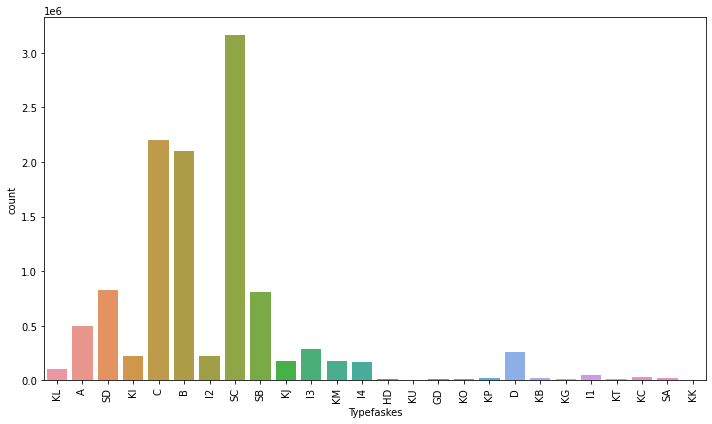

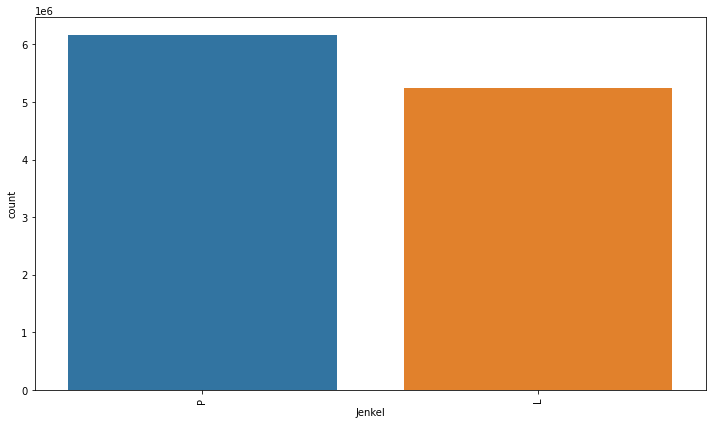

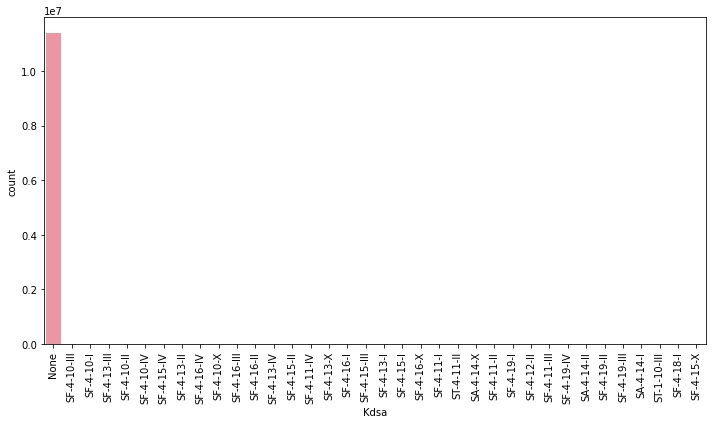

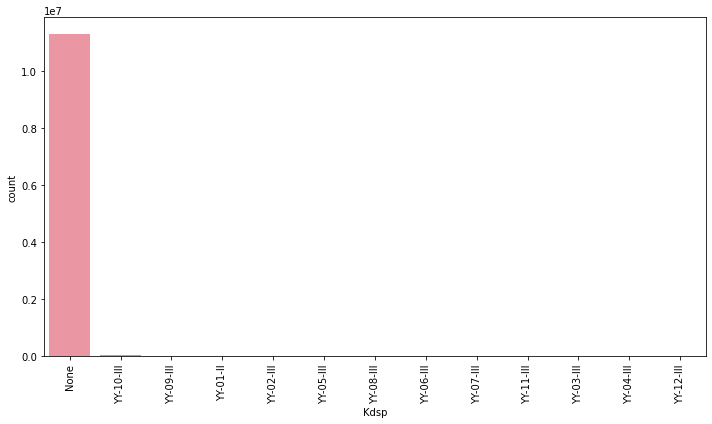

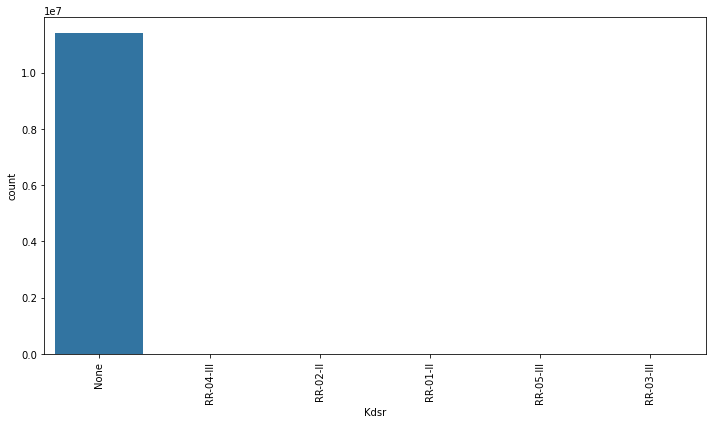

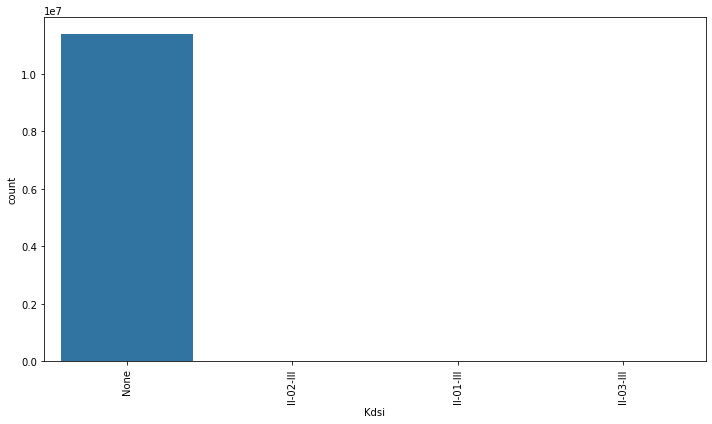

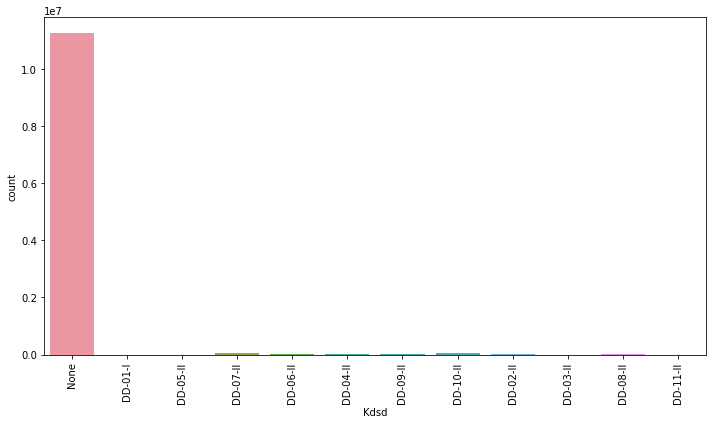

In [66]:
# Keseluruhan data object
plot_all_hist(df_update, label_object)

#### Hasil Analisis Perbedaan Label 0 dan 1

1. Kolom `typefaskes`: Dari keseluruhan data terdapat 26 jenis type fasilitas kesehatan. Pada label 0 masih terdapat 26 fasilitas, dan hasil visualisasinya pun tidak jauh berbeda. Namun pada label 1 hanya terdapat 25 fasilitas, dimana fasilitas **KL** tidak terdapat pada  label 1
2. Kolom `jenkel`: Pada kolom jenis kelamin tidak terdapat perbedaan dimana antara **P** dan **L** masih memiliki bentuk grafik yang sama
3. Kolom `kdsp`: Pada kolom ini data keseluruhan memiliki 13 jenis data dan pada label 0 juga memiliki 13 jenis data. Namun pada label 1 hanya terdapat 9 data, dimana 4 data yang tidak ada tersebut adalah **YY-01-II, YY-08-III, YY-06-III, YY-04-III, YY-12-III**
4. Kolom `kdsr`: Pada kolom ini data keseluruhan terdapat 6 jenis data dan pada label 0 juga terdapat 6 data. Tapi pada label 1 hanya terdapat 3 data, dimana 3 data yang tidak ada tersebut adalah **RR-02-II, RR-01-II, RR-03-III**
5. Kolom `kdsi`: Pada kolom ini data keseluruhan terdapat 4 jenis data dan pada label 0 juga terdapat 4 data, tapi pada label 1 hanya terdapat 2 jenis data saja, dimana data yang tidak ada tersebut adalah **II-01-III dan II-03-III**
6. Kolom `kdsd`: Pada kolom ini data keseluruhan terdapat 12 jenis data berbeda dan pada label 0 juga terdapat 12 data, namun pada label 1 hanya terdapat 11 jenis data yang berbeda. Dimana data dengan kode **DD-11-II** tidak tersedia pada label 1

Jadi inilah perbedaan antara data yang berlabel 0 dan data yang berlabel 1 yang terdapat pada kolom dengan type data object

In [67]:
def plot_all_numeric(df1, df2, columns):
    for col in columns:
        plt.figure(figsize=(14,6))
        plt.subplot(1,2,1)
        sns.histplot(x=col, data=df1)
        plt.xlabel(col.capitalize())
        plt.xticks(rotation='90')
        plt.tight_layout()
        plt.subplot(1,2,2)
        sns.histplot(x=col, data=df2)
        plt.xlabel(col.capitalize())
        plt.xticks(rotation='90')
        plt.tight_layout()
        plt.show()

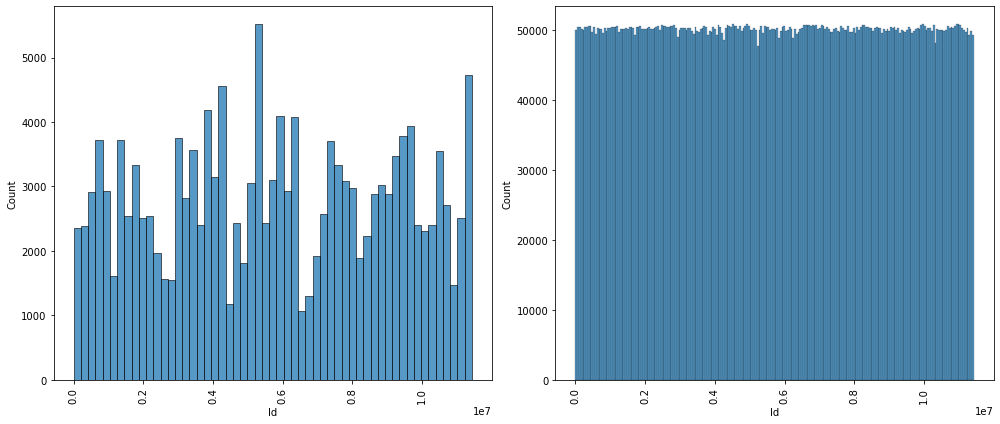

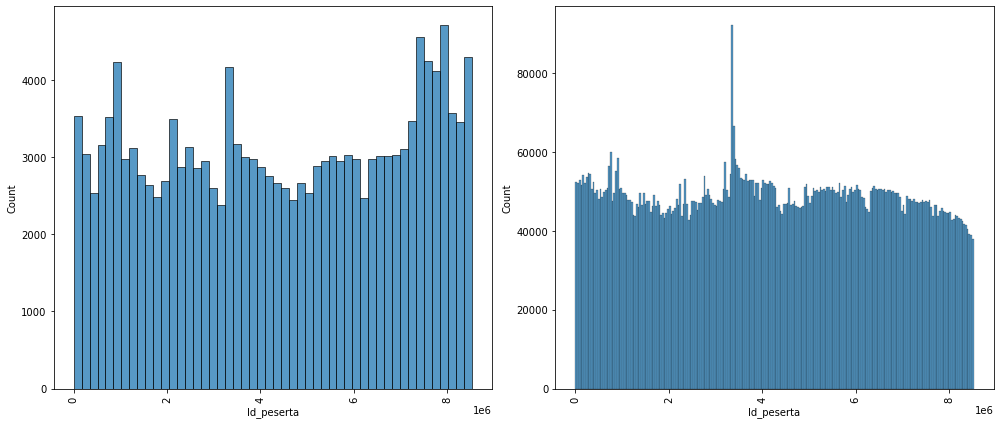

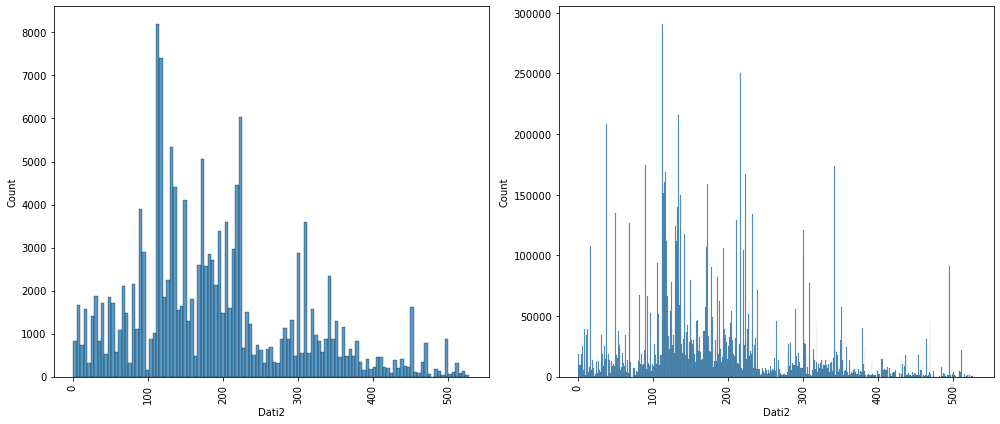

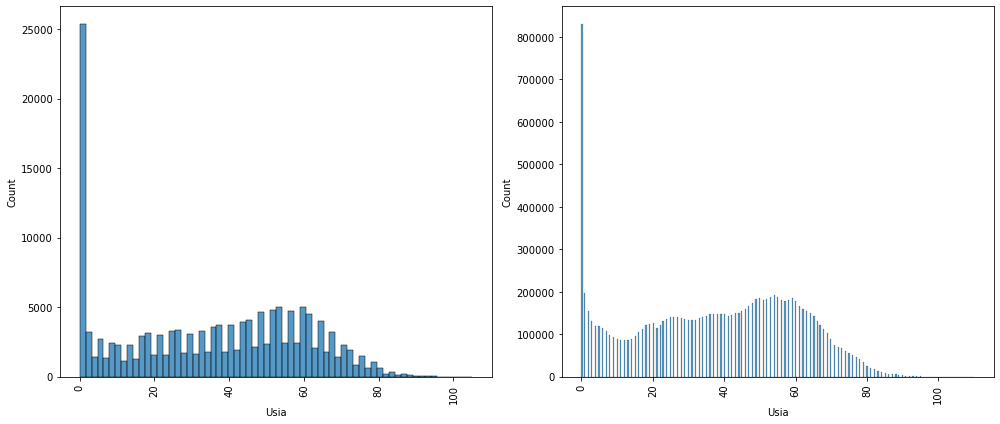

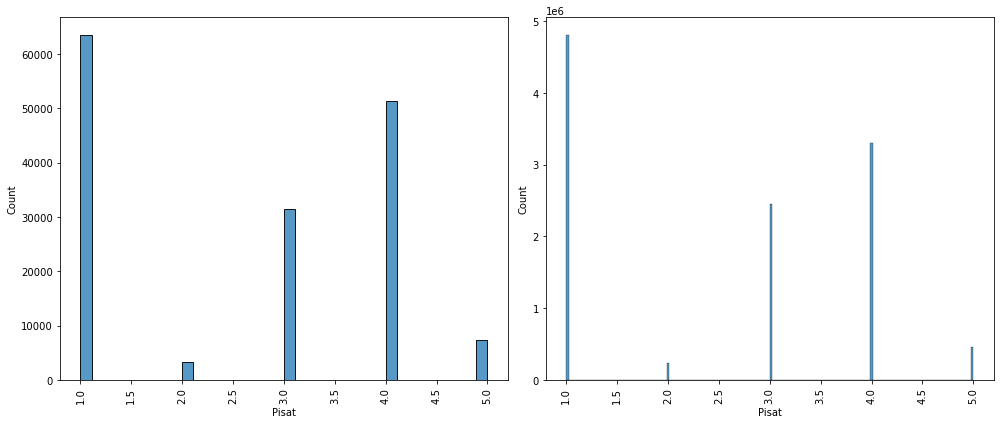

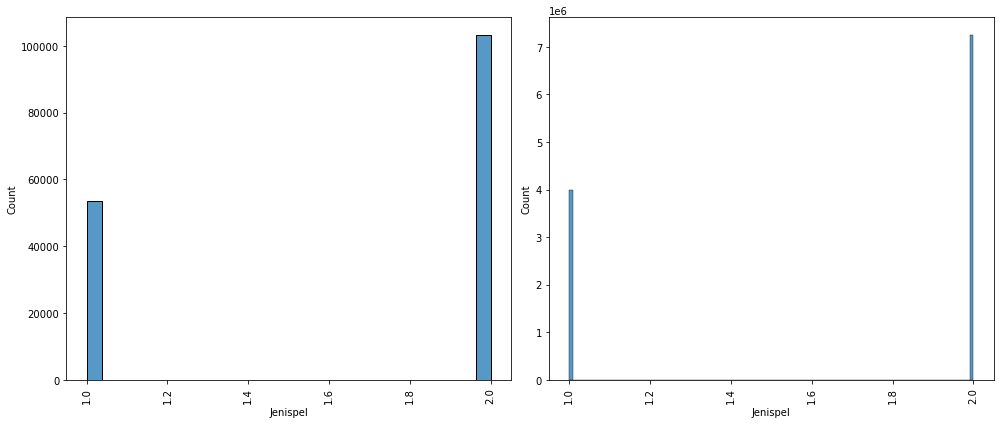

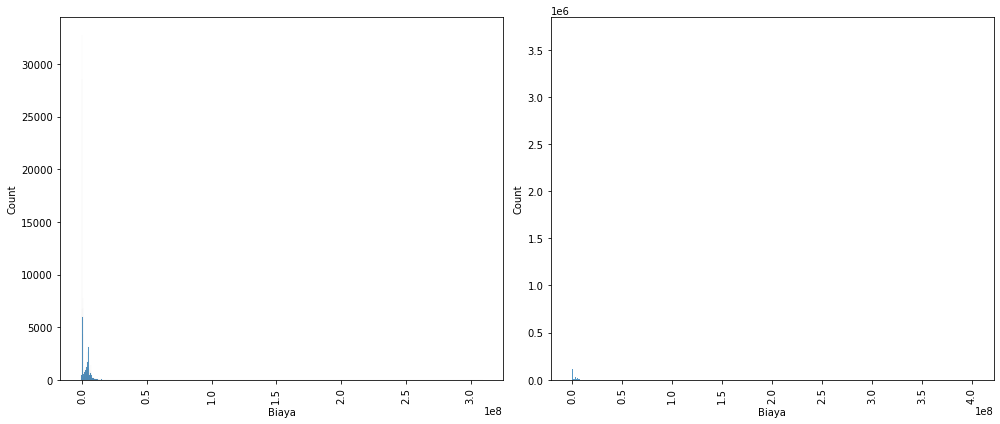

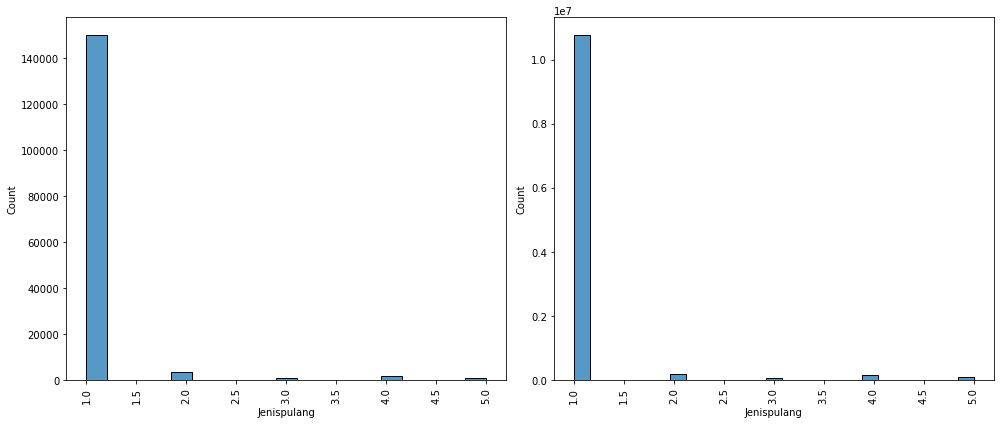

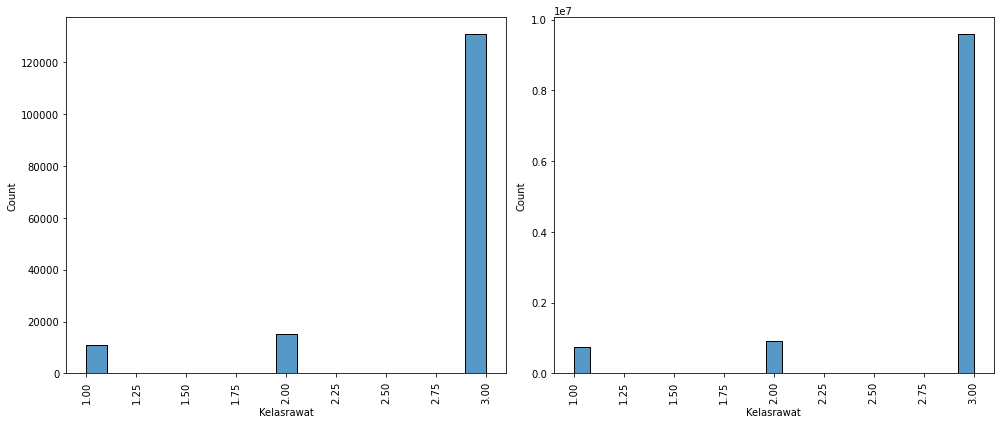

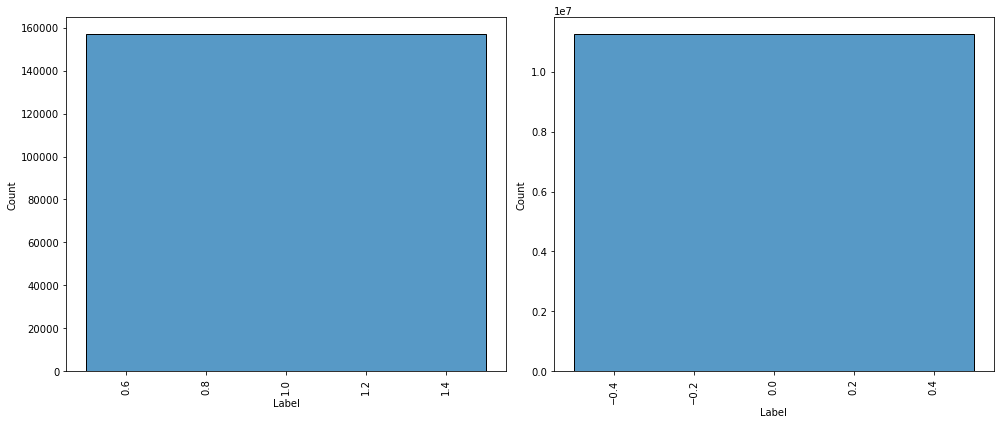

In [68]:
# Kiri label 1 kanan label 0
plot_all_numeric(label_1, label_0, num_cols)

Jika dilihat dari visualisasi data type numeric antara label 0 dan 1 tidak terlihat adanya perbedaan yang signifikan, baik dari data ordinal, nominal dan continue

## Feature Engineering

In [69]:
df_update.head()

,id,id_peserta,dati2,typefaskes,usia,jenkel,pisat,tgldatang,tglpulang,jenispel,biaya,jenispulang,kelasrawat,kdsa,kdsp,kdsr,kdsi,kdsd,label
0,165666,486,17,KL,48,P,1.0,2018-07-25 17:00:00+00:00,2018-07-25 17:00:00+00:00,2,184300.0,1.0,3,None,None,None,None,None,0
1,1010828,520,17,A,63,L,1.0,2019-05-27 17:00:00+00:00,2019-05-30 17:00:00+00:00,1,10628400.0,1.0,1,None,None,None,None,None,0
2,166042,523,17,KL,53,P,1.0,2019-07-16 17:00:00+00:00,2019-07-16 17:00:00+00:00,2,187300.0,1.0,3,None,None,None,None,None,0
3,168937,549,17,KL,54,P,1.0,2019-10-17 17:00:00+00:00,2019-10-17 17:00:00+00:00,2,187300.0,1.0,3,None,None,None,None,None,0
4,1005899,549,17,A,53,P,1.0,2018-04-18 17:00:00+00:00,2018-04-18 17:00:00+00:00,2,381600.0,1.0,3,None,None,None,None,None,0


In [70]:
df_update.isna().sum()

id             0
id_peserta     0
dati2          0
typefaskes     0
usia           0
jenkel         0
pisat          0
tgldatang      0
tglpulang      0
jenispel       0
biaya          0
jenispulang    0
kelasrawat     0
kdsa           0
kdsp           0
kdsr           0
kdsi           0
kdsd           0
label          0
dtype: int64

In [71]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Label Encoding pada kolom typefaskes
df_update['typefaskes'] = le.fit_transform(df_update['typefaskes'])
# Label Encodeing pada kolom kdsp
df_update['kdsp'] = le.fit_transform(df_update['kdsp'])
# Label Encoding pada kolom kdsd
df_update['kdsd'] = le.fit_transform(df_update['kdsd'])
# Label Encoding pada kolom kdsa
df_update['kdsa'] = le.fit_transform(df_update['kdsa'])
# Label Encoding pada kolom kdsr
df_update['kdsr'] = le.fit_transform(df_update['kdsr'])
# Label Encoding pada kolom kdsi
df_update['kdsi'] = le.fit_transform(df_update['kdsi'])

Kita menggunakan Label Encoding pada ketiga kolom tersebut karena kolom tersebut memiliki data unique > 9, karena jika kita menggunakan One Hot Encoding maka akan menambahkan banyak kolom baru, dan itu akan membuat pemodelan menjadi lebih lama

In [72]:
df_update.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11401882 entries, 0 to 11401881
Data columns (total 19 columns):
 #   Column       Dtype              
---  ------       -----              
 0   id           int64              
 1   id_peserta   int64              
 2   dati2        int64              
 3   typefaskes   int32              
 4   usia         int64              
 5   jenkel       object             
 6   pisat        float64            
 7   tgldatang    datetime64[ns, UTC]
 8   tglpulang    datetime64[ns, UTC]
 9   jenispel     int64              
 10  biaya        float64            
 11  jenispulang  float64            
 12  kelasrawat   int64              
 13  kdsa         int32              
 14  kdsp         int32              
 15  kdsr         int32              
 16  kdsi         int32              
 17  kdsd         int32              
 18  label        int64              
dtypes: datetime64[ns, UTC](2), float64(3), int32(6), int64(7), object(1)
memory usage:

In [74]:
df_update.to_parquet('data/sementara.parquet')

In [1]:
import pandas as pd
df_update = pd.read_parquet('data/sementara.parquet')
# Select colom
one_hot_columns = df_update.select_dtypes('object').columns

# One Hot Encoding dengan pandas
df_in = pd.get_dummies(df_update, columns=one_hot_columns)

In [2]:
# Membuat kolom durasi
df_in['durasi'] = df_in['tglpulang']-df_in['tgldatang']

# Convert waktu ke format asia
df_in['tgldatang'] = df_in['tgldatang'].dt.tz_convert('Asia/Jakarta')
df_in['tglpulang'] = df_in['tglpulang'].dt.tz_convert('Asia/Jakarta')

# Mengubahnya menjadi integer dan dibagi 3600000000000 untuk merubah ke interval jam
df_in['durasi'] = df_in['durasi'].astype('int64')/3600000000000 

# Menghapus kolom tgldatang, tglpulang dan id
df_in.drop(['tgldatang', 'tglpulang', 'id'], axis=1, inplace=True)

print(df_in.shape)

C:\Users\feryi\AppData\Local\Temp\ipykernel_8284\3746197675.py:9: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df_in['durasi'] = df_in['durasi'].astype('int64')/3600000000000


(11401882, 18)


In [3]:
# Menyimpan data bersih
df_in.to_parquet('data/data_clean_inbalance.parquet')

0    11244993
1      156889
Name: label, dtype: int64


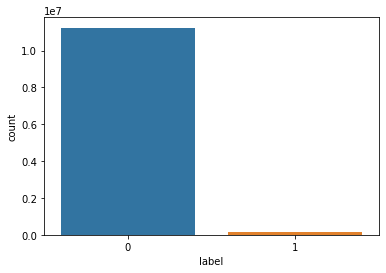

In [1]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import data inbalance
df = pd.read_parquet('data/data_clean_inbalance.parquet')

sns.countplot(df.label)
print(df.label.value_counts())

In [2]:
df.shape

(11401882, 18)

Karena label yang merupakan inbalance problem maka kita akan melakukan Resample(Over Sampling) pada dataset, ini berguna agar kita memiliki data yang balance antara class 0 dan 1 untuk variabel dependen

In [3]:
df.columns

Index(['id_peserta', 'dati2', 'typefaskes', 'usia', 'pisat', 'jenispel',
       'biaya', 'jenispulang', 'kelasrawat', 'kdsa', 'kdsp', 'kdsr', 'kdsi',
       'kdsd', 'label', 'jenkel_L', 'jenkel_P', 'durasi'],
      dtype='object')

In [4]:
from sklearn.utils import resample

#create two different dataframe of majority and minority class 
df_majority = df[(df['label']==0)] 
df_minority = df[(df['label']==1)] 

# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    
                                 n_samples= 11244993, 
                                 random_state=42)  

# Combine majority class with upsampled minority class
df_balance = pd.concat([df_minority_upsampled, df_majority])

# Save data yang telah di lakukan oversampling
df_balance.to_parquet('data/data_clean_balance.parquet')

In [5]:
df_balance.shape

(22489986, 18)

In [70]:
df_in.columns

Index(['id_peserta', 'dati2', 'typefaskes', 'usia', 'pisat', 'jenispel',
       'biaya', 'jenispulang', 'kelasrawat', 'kdsa', 'kdsp', 'kdsr', 'kdsi',
       'kdsd', 'jenkel_L', 'jenkel_P', 'durasi'],
      dtype='object')

## Modeling

Kolom yang akan kita gunakan untuk melakukan prediksi terhadap efisiensi pelayanan pada BPJS Kesehatan terdapat 23 kolom yaitu:
1. `id_peserta`: id peserta juga kita gunakan untuk melatih model agar mengenali id BPJS pengunjung
2. `dati2`: Kolom ini berisi lokasi (kab/kota)  fasilitas kesehatan 
3. `typefaskes`: Adalah jenis fasilitas kesehatan yang di tawarkan oleh BPJS kesehatan
4. `usia`: Kolom berisi usia pengunjung 
5. `pisat`: Kolom hubungan kepesertaan dimana yang terdaftar merupakan anggota keluarga dan sebagainya
6. `jenispel`: Kolom berisi jenis pelayanan yang disediakan BPJS
7. `biaya`: adalah biaya yang di keluarkan pengunjung
8. `jenispulang`:Keadaan pengunjung setelah selesai melakukan pelayanan pada BPJS
9. `kelasrawat`: Kelas/tingkatan kamar yang di pesan oleh pengunjung
10. `kdsp`: Kolom Kode Special Procedures
11. `kdsd`: Kolom Kode Special Drugs
12. `kdsa`: Kolom Kode Special Sub-Acute Group
13. `kdsi`: Kolom Kode Special Investigation
14. `kdsr`: Kolom Kode Special Proteshis
15. `jenkel_L`: Jenis kelamin laki-laki yang telah dilakukan One-Hot Encode
16. `jenkel_P`: Jenis kelamin perempuan yang telah dilakukan One-Hot Encode
17. `durasi`: Lama waktu pelayanan pengunjung BPJS Kesehatan

1    11244993
0    11244993
Name: label, dtype: int64


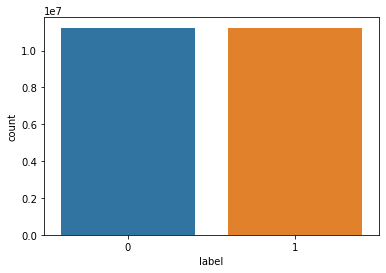

In [1]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# lokasi data balance
path = 'data/data_clean_balance.parquet'

# Read data balance
df = pd.read_parquet(path)

sns.countplot(df.label)
print(df.label.value_counts())

In [2]:
print(df.shape)
print(df.columns)

(22489986, 18)
Index(['id_peserta', 'dati2', 'typefaskes', 'usia', 'pisat', 'jenispel',
       'biaya', 'jenispulang', 'kelasrawat', 'kdsa', 'kdsp', 'kdsr', 'kdsi',
       'kdsd', 'label', 'jenkel_L', 'jenkel_P', 'durasi'],
      dtype='object')


In [3]:
# Splitting dataset dengan scikit-learn
from sklearn.model_selection import train_test_split

# Select variabel X dan Y
X = df.drop('label', axis=1)
y = df['label']

In [4]:
print(df.shape)
print(X.shape)
print(y.shape)

(22489986, 18)
(22489986, 17)
(22489986,)


In [5]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [6]:
y_test.shape

(2248999,)

In [7]:
X_min = X_test
y_min = y_test

X_train, X_test, y_train, y_test = train_test_split(X_min, y_min, test_size=0.3)

In [8]:
X_last = X_test
y_last = y_test

X_train, X_test, y_train, y_test = train_test_split(X_last, y_last, test_size=0.3)

In [9]:
X_test.shape

(202410, 17)

Untuk pemodelan kami hanya menggunakan 944579 data train dan 202410 baris untuk data test secara random karena agar tidak memakan komputasi yang banyak serta tidak memakan banyak waktu. Karena proses ini hanya untuk mencari tahu algoritma machine learning terbaik yang akan kita gunakan untuk pemodelan akhir.

### Logistic Regression

In [13]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression().fit(X_train, y_train)

lr_pred = lr.predict(X_test)

print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.52      0.06      0.11    101407
           1       0.50      0.95      0.65    101003

    accuracy                           0.50    202410
   macro avg       0.51      0.50      0.38    202410
weighted avg       0.51      0.50      0.38    202410



### K-Nearest Neighbors

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier().fit(X_train, y_train)

knn_pred = knn.predict(X_test)
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.81      0.74      0.77    101012
           1       0.76      0.82      0.79    101398

    accuracy                           0.78    202410
   macro avg       0.78      0.78      0.78    202410
weighted avg       0.78      0.78      0.78    202410



### Decision Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt_model = dt.fit(X_train, y_train)

dt_pred = dt_model.predict(X_test)
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88    101407
           1       0.85      0.94      0.89    101003

    accuracy                           0.89    202410
   macro avg       0.89      0.89      0.89    202410
weighted avg       0.89      0.89      0.89    202410



### Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf_model = rf.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92    101407
           1       0.91      0.92      0.92    101003

    accuracy                           0.92    202410
   macro avg       0.92      0.92      0.92    202410
weighted avg       0.92      0.92      0.92    202410



### Gradient Boosting

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=42)
gbc_model = gbc.fit(X_train, y_train)

gbc_pred = gbc_model.predict(X_test)
print(classification_report(y_test, gbc_pred))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72    101407
           1       0.72      0.68      0.70    101003

    accuracy                           0.71    202410
   macro avg       0.71      0.71      0.71    202410
weighted avg       0.71      0.71      0.71    202410



### Gausian Naive Bayes

In [17]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

model_gnb = gnb.fit(X_train, y_train)

gnb_pred = model_gnb.predict(X_test)
print(classification_report(y_test, gnb_pred))

              precision    recall  f1-score   support

           0       0.51      0.64      0.57    101407
           1       0.52      0.40      0.45    101003

    accuracy                           0.52    202410
   macro avg       0.52      0.52      0.51    202410
weighted avg       0.52      0.52      0.51    202410



## Evaluation

Bisa di lihat dari beberapa model yang telah kita pilih, terlihat data pada kasus ini lebih cocok menggunakan model pohon keputusan yaitu seperti
- Decision Tree
- Random Forest

Namun ada hal yang membuat kita sedikit bertanya-tanya, yaitu pada model **`Gradient Boosting`**

Padahal model ini juga berupa model dengan pohon keputusan, namun performanya berbeda jauh dengan **`Decision Tree`** yang merupakan model pohon keputusan sesungguhnya

Perkiraan kita sebelumnya adalah model **`Gradient Boosting`** seharusnya lebih bagus, karena model ini bekerja dengan melakukan pemodelan ulang pada pohon keputusan.

Karena penasaran maka kita coba dengan mencari berapa banyak pohon keputusan terbaik 

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

error_list = list()

tree_list = [15, 25, 50, 100, 200, 400]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, random_state=42)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    GBC.fit(X_train.values, y_train.values)
    gbc_pred = GBC.predict(X_test)

    # Get the error
    error = 1.0 - accuracy_score(y_test, gbc_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

Fitting model with 15 trees
Fitting model with 25 trees
Fitting model with 50 trees
Fitting model with 100 trees
Fitting model with 200 trees
Fitting model with 400 trees


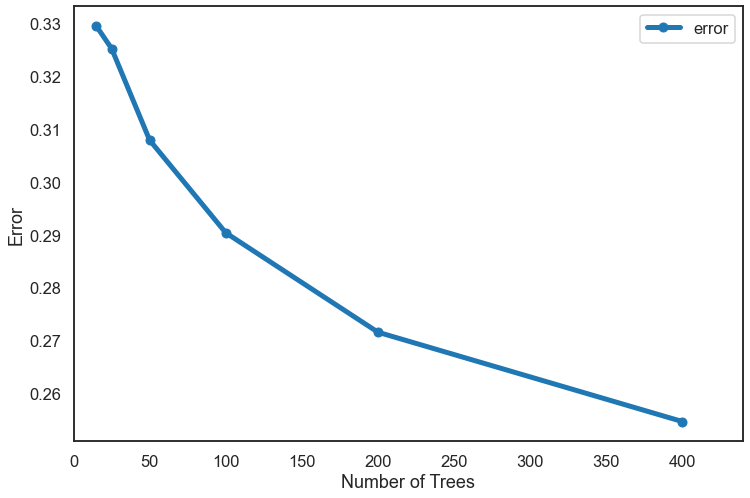

In [16]:
sns.set_context('talk')
sns.set_style('white')
#sns.set_palette(palette)

# Create the plot
ax = error_df.plot(marker='o', figsize=(12, 8), linewidth=5)

# Set parameters
ax.set(xlabel='Number of Trees', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.1);

**`Gradient Boosting`** memerlukan banyak pohon keputusan untuk mendapatkan performa model yang baik, terlihat pada grafik bahwa semakin banyak pohon maka error yang dihasilkan semakin sedikit. Sebenarnya model ini bisa saja menjadi lebih baik jika kita melakukan hyperparameter dengan pemilihan nilai yang cukup besar seperti memperbanyak jumlah pohon, namun proses ini akan memakan komputasi dan waktu yang banyak.

Mari kita coba dengan model Random Forest

#### Banyaknya Pohon (n_estimators)

In [18]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_list = list()
precision

# Set banyaknya pohon
tree_list = [15, 25, 50, 100, 200, 400]
for n_trees in tree_list:
    
    # Inisialisasi Random Forest
    RF = RandomForestClassifier(n_estimators=n_trees, random_state=42)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    RF.fit(X_train.values, y_train.values)
    rf_pred = RF.predict(X_test)

    # Mencari nilai error
    error = 1.0 - accuracy_score(y_test, rf_pred)
    
    # Masukan kedalam dataframe
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

Fitting model with 15 trees
Fitting model with 25 trees
Fitting model with 50 trees
Fitting model with 100 trees
Fitting model with 200 trees
Fitting model with 400 trees


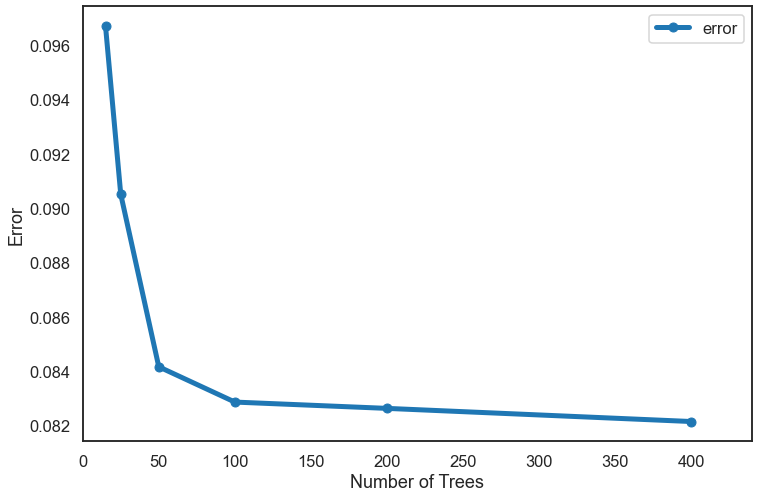

In [19]:
import seaborn as sns

sns.set_context('talk')
sns.set_style('white')

# Create the plot
ax = error_df.plot(marker='o', figsize=(12, 8), linewidth=5)

# Set parameters
ax.set(xlabel='Number of Trees', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.1);

Terlihat untuk model **`Random Forest`** mulai lebih baik performanya pada pembentukan 100 pohon keputusan, dimana jumlah ini adalah default yang telah ditetapkan oleh **`scikit-learn`** pantas saja meskipun kita tidak melakukan setting parameter namun performa dari model ini sudah cukup baik sehingga kita tidak perlu melakukan hyperparameter tuning pada model ini.

#### Kedalaman/Panjang Pohon (max_depth)

In [19]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

error_list = list()

depth_list = [int(x) for x in np.linspace(10, 110, num=11)]
for depth in depth_list:
    
    # Initialize the gradient boost classifier
    RF = RandomForestClassifier(max_depth=depth, random_state=42)

    # Fit the model
    print(f'Fitting model with {depth} depth')
    RF.fit(X_train.values, y_train.values)
    rf_pred = RF.predict(X_test)

    # Get the error
    error = 1.0 - accuracy_score(y_test, rf_pred)
    
    # Store it
    error_list.append(pd.Series({'n_depth': depth, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_depth')

Fitting model with 10 depth
Fitting model with 20 depth
Fitting model with 30 depth
Fitting model with 40 depth
Fitting model with 50 depth
Fitting model with 60 depth
Fitting model with 70 depth
Fitting model with 80 depth
Fitting model with 90 depth
Fitting model with 100 depth
Fitting model with 110 depth


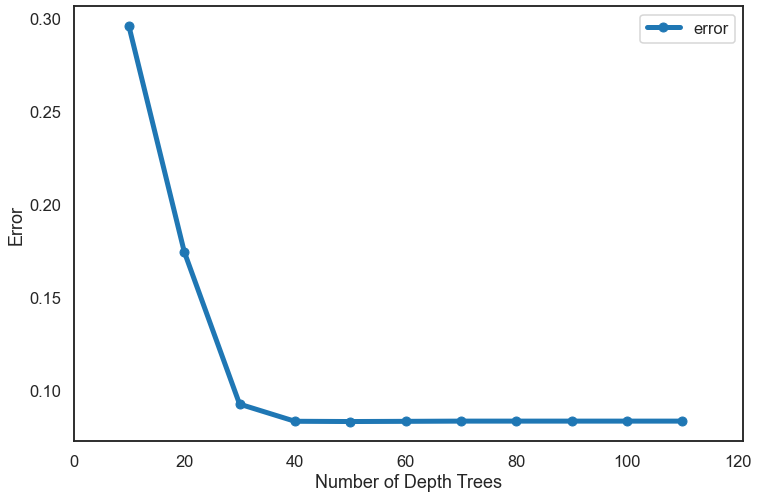

In [20]:
import seaborn as sns

sns.set_context('talk')
sns.set_style('white')

# Create the plot
ax = error_df.plot(marker='o', figsize=(12, 8), linewidth=5)

# Set parameters
ax.set(xlabel='Number of Depth Trees', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.1);

Ini mengejutkan, ternyata dengan menambahkan kedalaman panjang dari pohon keputusan `(max-depth)` bisa membuat model Random Forest memiliki eror di bawah 0.05 dari kedalaman 40, mari kita coba dengan parameter lain.

#### Minimum Pengamatan Sempel (min_samples_split)

In [24]:
error_list = list()

split_list = [2, 4, 6, 8, 10]
for split in split_list:
    
    # Initialize the gradient boost classifier
    RF = RandomForestClassifier(min_samples_split=split, random_state=42)

    # Fit the model
    print(f'Fitting model with {split} Min sample split')
    RF.fit(X_train.values, y_train.values)
    rf_pred = RF.predict(X_test)

    # Get the error
    error = 1.0 - accuracy_score(y_test, rf_pred)
    
    # Store it
    error_list.append(pd.Series({'n_split': split, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_split')

Fitting model with 2 Min sample split
Fitting model with 4 Min sample split
Fitting model with 6 Min sample split
Fitting model with 8 Min sample split
Fitting model with 10 Min sample split


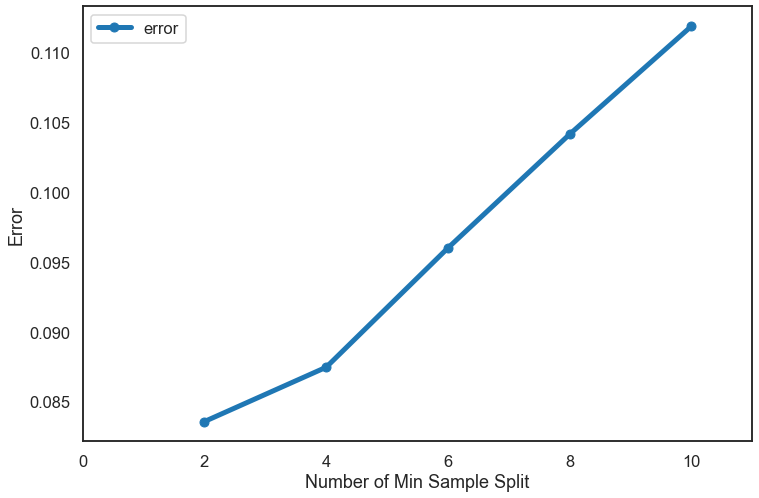

In [25]:
import seaborn as sns

sns.set_context('talk')
sns.set_style('white')

# Create the plot
ax = error_df.plot(marker='o', figsize=(12, 8), linewidth=5)

# Set parameters
ax.set(xlabel='Number of Min Sample Split', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.1);

Ternyata dnegan menambahkan pengamatan sempel `(min_samples_split)` malah memperbesar nilai error nya, artinya model Random Forest sudah lebih baik pada default pengamatan dari scikit-learn yaitu 2.

#### Minimum Pembentkan Daun (min_samples_leaf)

In [38]:
error_list = list()

leaf_list = [1,2,3,4,5,6,7,8,9,10]
for leaf in leaf_list:
    
    # Initialize the gradient boost classifier
    RF = RandomForestClassifier(min_samples_leaf=leaf, random_state=42)

    # Fit the model
    print(f'Fitting model with {leaf} Min Leaf')
    RF.fit(X_train.values, y_train.values)
    rf_pred = RF.predict(X_test)

    # Get the error
    error = 1.0 - accuracy_score(y_test, rf_pred)
    
    # Store it
    error_list.append(pd.Series({'n_leaf': leaf, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_leaf')

Fitting model with 1 Min Leaf
Fitting model with 2 Min Leaf
Fitting model with 3 Min Leaf
Fitting model with 4 Min Leaf
Fitting model with 5 Min Leaf
Fitting model with 6 Min Leaf
Fitting model with 7 Min Leaf
Fitting model with 8 Min Leaf
Fitting model with 9 Min Leaf
Fitting model with 10 Min Leaf


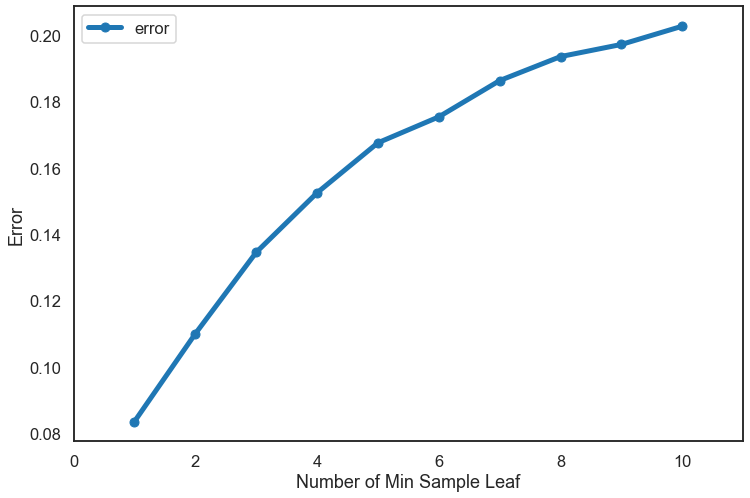

In [39]:
import seaborn as sns

sns.set_context('talk')
sns.set_style('white')

# Create the plot
ax = error_df.plot(marker='o', figsize=(12, 8), linewidth=5)

# Set parameters
ax.set(xlabel='Number of Min Sample Leaf', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.1);

Untuk nilai minimum dari daun yang di bentuk `(min_samples_leaf)` juga semakin tinggi nilainya maka semakil buruk model yang di hasilkan, artinya model Random Forest sudah baik dengan min_samples_leaf default nya dari scikit-learn yaitu 1

#### Maximum Pengamatan Feature (max_features)

In [30]:
error_list = list()

feature_list = ['sqrt', 'log2', 'auto']
for feature in feature_list:
    
    # Initialize the gradient boost classifier
    RF = RandomForestClassifier(max_features=feature, random_state=42)

    # Fit the model
    print(f'Fitting model with {feature} Min Leaf')
    RF.fit(X_train.values, y_train.values)
    rf_pred = RF.predict(X_test)

    # Get the error
    error = 1.0 - accuracy_score(y_test, rf_pred)
    
    # Store it
    error_list.append(pd.Series({'n_feature': feature, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_feature')

Fitting model with sqrt Min Leaf
Fitting model with log2 Min Leaf
Fitting model with auto Min Leaf


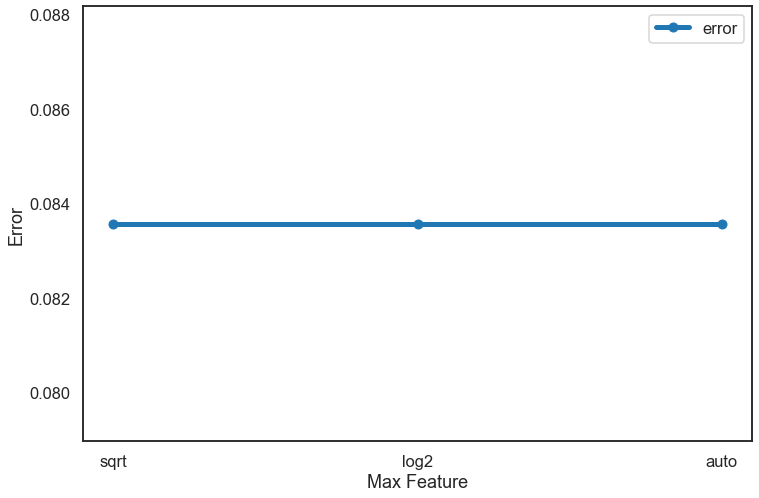

In [36]:
import seaborn as sns

sns.set_context('talk')
sns.set_style('white')

# Create the plot
ax = error_df.plot(marker='o', figsize=(12, 8), linewidth=5)

# Set parameters
ax.set(xlabel='Max Feature', ylabel='Error');

Dari ketiga Max Feature ternhyata memiliki performa yang sama baik `auto, sqrt dan log2`. 

Sekarang kita akan mencoba melihat performa dengan parameter yang kita tentukan sendiri dan parameter yang di tentukan oleh **GridSearchCV** untuk menentukan model yang terbaik.

In [15]:
from sklearn.ensemble import RandomForestClassifier
# Hyperparameter dengan pilihan sendiri
rf = RandomForestClassifier(n_estimators=400,
                           max_depth=60,
                           min_samples_split=2,
                           min_samples_leaf=1,
                           max_features='sqrt',
                           n_jobs=-1, verbose=1,
                           random_state=42)

my_model = rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  8.8min finished


Setelah kita melakukan beberapa penyesuaian pada parameter Random Forest bisa dilihat model ini memang cukup baik untuk kasus dataset ini.

Akhirnya kami putuskan untuk memilih **`Random Forest Classifier`** sebagai model yang akan kita gunakan untuk membangun machine learning pada dataset ini.

In [73]:
# Save model
import pickle
 
# Build Hasil Model default
pickle.dump(open(model, 'random_forest.pkl', 'rb'))  

## Conclusion
Ketika menganalisa data kita tidak menemukan adanya perbedaan yang cukup signifikan antara pelayanan yang tergolong `efisien` dan `inefisien`, namun ada beberapa temuan seperti: 
- Pada kolom-kolom Kode Special terdapat perbedaan antara label 0 dan 1, dimana pada label tidak semua kode special terdapat di label tersebut.
- Pada koom biaya, nilai maximum biaya pada label 1 hanya sekitar 309451300.0 sedangkan dari keseluruhan data dan label 0 biaya maximum sebesar 401696600.0

Karena kita tidak bisa mengambil kesimpulan dari analisa tersebut untuk menentukan seperti apa saja transaksi yang tergolong `efisien` dan `inefisien` maka kita akan menggunakan Machine Learning untuk memprediksinya.

Model Machine Learning yang kita bangun dengan 24 kolom yaitu `'id_peserta', 'dati2', 'typefaskes', 'usia', 'pisat', 'jenispel', 'biaya', 'jenispulang', 'kelasrawat', 'kdsa', 'kdsp', 'kdsr', 'kdsi','kdsd', 'jenkel_L', 'jenkel_P', 'durasi'` untuk melakukan prediksi terhadap efisiensi pelayana  BPJS kesehatan `'label'`.

Pada pemilihan model machine learning kita memilih untuk menggunakan **`Random Forest Classifier`** karena model ini memiliki performa baik pada dataset yang kita gunakan.

Melakukan penyesuaian parameter pada **Random Forest** untuk melihat seberapa perubahan jika kita melakukan hyperparameter, namun karena diantara beberapa parameter ada yang sudah baik pada default *Scikit-Learn* maka kita tidak melakukan hyperparameter tuning pada model yang telah kita pilih karena model **`Random Forest`** sudah memiliki performa yang cukup baik pada kasus dataset ini. dengan performa pada train sempel data 944579 dengan performa accuracy 92% pada 202410 data tes.

### Predict Data Penyisihan Wilayah

In [1]:
import pandas as pd

df = pd.read_csv('data/sampling2_healthkathon2022_sep.csv')

In [2]:
df.shape

(998941, 21)

In [3]:
df.columns

Index(['id', 'id_peserta', 'dati2', 'typefaskes', 'usia', 'jenkel', 'pisat',
       'tgldatang', 'tglpulang', 'jenispel', 'politujuan', 'diagfktp', 'biaya',
       'jenispulang', 'cbg', 'kelasrawat', 'kdsa', 'kdsp', 'kdsr', 'kdsi',
       'kdsd'],
      dtype='object')

In [4]:
df.isna().sum()

id                  0
id_peserta          0
dati2               0
typefaskes          0
usia                0
jenkel              6
pisat               6
tgldatang           0
tglpulang           0
jenispel            0
politujuan     108148
diagfktp           64
biaya            5049
jenispulang         3
cbg                 0
kelasrawat          0
kdsa            20804
kdsp            20732
kdsr            20803
kdsi            20785
kdsd            20789
dtype: int64

In [5]:
# Function check presentase data hilang
def hilang(data):
    miss = data.isna().mean()*100
    print('Missing: {:.2f}%'.format(miss))

In [6]:
print(hilang(df.politujuan))
print(hilang(df.biaya))
print(hilang(df.kdsp))

Missing: 10.83%
None
Missing: 0.51%
None
Missing: 2.08%
None


In [7]:
# Merubah type object menjadi datetime
df['tgldatang'] = pd.to_datetime(df['tgldatang'], format='%Y-%m-%d %H:%M:%S')
df['tglpulang'] = pd.to_datetime(df['tglpulang'], format='%Y-%m-%d %H:%M:%S')

In [8]:
# Mengisi nilai hilang kolom pisat
df['pisat'] = df['pisat'].fillna(df['pisat'].mode()[0])

In [9]:
# Mengisi nilai hilang di kolom pisat
df['jenispulang'] = df['jenispulang'].fillna(df['jenispulang'].mode()[0])

In [10]:
# mengisi kolom biaya dengan regresi
from sklearn.linear_model import LinearRegression
# Membuat sebuah LinearRegression
lr = LinearRegression()

# Seleksi kolom-kolom yang digunakan
selected_cols = ['biaya', 'id', 'id_peserta', 'dati2', 'jenispel', 'kelasrawat']

# Bagi menjadi Missing dan Training. Missing Df berisi baris-baris dengan 'Biaya' kosong.
missing_df = df[df['biaya'].isnull()==True][selected_cols]
training_df = df[df['biaya'].isnull()==False][selected_cols]

# Buatlah model regression dari baris-baris yang tidak memiliki missing values
y_train = training_df['biaya']
x_train = training_df.drop('biaya', axis = 1)

lr.fit(x_train, y_train)

# Prediksilah nilai 'Biaya' pada baris-baris yang memiliki missing values
x_missing = missing_df.drop('biaya', axis = 1)

prediction = lr.predict(x_missing)
missing_df['biaya'] = prediction

In [11]:
### Combine all into one dataframe
df_full = pd.concat([training_df, missing_df])
df_full = df_full.sort_index()

In [12]:
# Memasukan nilai prediksi biaya 
df = df.copy()
df[selected_cols] = df_full[selected_cols]

In [13]:
# Pilih nama kolom
hapus = ['diagfktp', 'politujuan', 'cbg']

# Hapus kolom
df.drop(hapus, axis=1, inplace=True)

In [14]:
# Mengisi data hilang dengan mode
df['jenkel'] = df['jenkel'].fillna('P')

In [15]:
# Mengisi kolom kode spesial
df['kdsr'] = df['kdsr'].fillna(method='pad')
df['kdsi'] = df['kdsi'].fillna(method='pad')
df['kdsp'] = df['kdsp'].fillna(method='pad')
df['kdsd'] = df['kdsd'].fillna(method='pad')
df['kdsa'] = df['kdsa'].fillna(method='pad')

In [16]:
df.isna().sum()

id             0
id_peserta     0
dati2          0
typefaskes     0
usia           0
jenkel         0
pisat          0
tgldatang      0
tglpulang      0
jenispel       0
biaya          0
jenispulang    0
kelasrawat     0
kdsa           0
kdsp           0
kdsr           0
kdsi           0
kdsd           0
dtype: int64

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Label Encoding pada kolom typefaskes
df['typefaskes'] = le.fit_transform(df['typefaskes'])
# Label Encodeing pada kolom kdsp
df['kdsp'] = le.fit_transform(df['kdsp'])
# Label Encoding pada kolom kdsd
df['kdsd'] = le.fit_transform(df['kdsd'])
# Label Encoding pada kolom kdsr
df['kdsr'] = le.fit_transform(df['kdsr'])
# Label Encoding pada colom kdsi
df['kdsi'] = le.fit_transform(df['kdsi'])
# Label Encode pada kolom kdsa
df['kdsa'] = le.fit_transform(df['kdsa'])

In [18]:
# Select colom
one_hot_columns = df.select_dtypes('object').columns

# One Hot Encoding dengan pandas
df_in = pd.get_dummies(df, columns=one_hot_columns)

In [19]:
# Membuat kolom durasi
df_in['durasi'] = df_in['tglpulang']-df_in['tgldatang']

# Convert waktu ke format asia
df_in['tgldatang'] = df_in['tgldatang'].dt.tz_convert('Asia/Jakarta')
df_in['tglpulang'] = df_in['tglpulang'].dt.tz_convert('Asia/Jakarta')

# Mengubahnya menjadi integer dan dibagi 3600000000000 untuk merubah ke interval jam
df_in['durasi'] = df_in['durasi'].astype('int64')/3600000000000 

# Menghapus kolom tgldatang, tglpulang dan id
df_in.drop(['tgldatang', 'tglpulang', 'id'], axis=1, inplace=True)

C:\Users\feryi\AppData\Local\Temp\ipykernel_8104\4215129999.py:9: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df_in['durasi'] = df_in['durasi'].astype('int64')/3600000000000


In [28]:
import warnings
warnings.filterwarnings('ignore')
import pickle

# Import model 
model = pickle.load(open('model/random_forest.pkl', 'wb'))

In [29]:
# predic data test
pred = model.predict(df_in)

In [30]:
tes = pd.DataFrame({
    'id':df_in.id,
    'label':pred
})

In [31]:
tes.to_csv('answer.csv', index=False)